## Ссылка на kaggle dataset

https://www.kaggle.com/datasets/egorkainov/moscow-housing-price-dataset/data

## Установка и импорт библиотек

#### Установка библиотеки tpot (AutoML)

In [ ]:
!pip install TPOT

#### Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings
from tpot import TPOTRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import drive

## Подгрузка google disk

In [ ]:
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Загрузка датасета и настроек

#### Загрузка датасета

In [ ]:
df_moscow_flats = pd.read_csv("/content/drive/MyDrive/Moscow Flats/MoscowFlats.csv")

#### Загрузка настроек

In [ ]:
pd.set_option('display.float_format', '{:.6f}'.format)
sns.set(style="whitegrid", rc={'figure.figsize': (12, 6), 'figure.dpi': 100})

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Первичный анализ

### Проверка на наличие дубликатов

In [ ]:
df_moscow_flats.shape

(22676, 12)

In [ ]:
df_moscow_flats = df_moscow_flats.drop_duplicates().reset_index(drop=True)
df_moscow_flats.shape

(20841, 12)

---
**Вывод:**

В исходных данных обнаружены дубликаты в количестве 1835 записей. Несмотря на вероятность того, что это могут быть разные квартиры, их присутствие может негативно повлиять на дальнейший анализ и обучение моделей, поэтому они были исключены.

---

### Вкратце посмотрим на данные и проверим на отсутствие пропусков

In [ ]:
df_moscow_flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20841 entries, 0 to 20840
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             20841 non-null  float64
 1   Apartment type    20841 non-null  object 
 2   Metro station     20841 non-null  object 
 3   Minutes to metro  20841 non-null  float64
 4   Region            20841 non-null  object 
 5   Number of rooms   20841 non-null  float64
 6   Area              20841 non-null  float64
 7   Living area       20841 non-null  float64
 8   Kitchen area      20841 non-null  float64
 9   Floor             20841 non-null  float64
 10  Number of floors  20841 non-null  int64  
 11  Renovation        20841 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 1.9+ MB


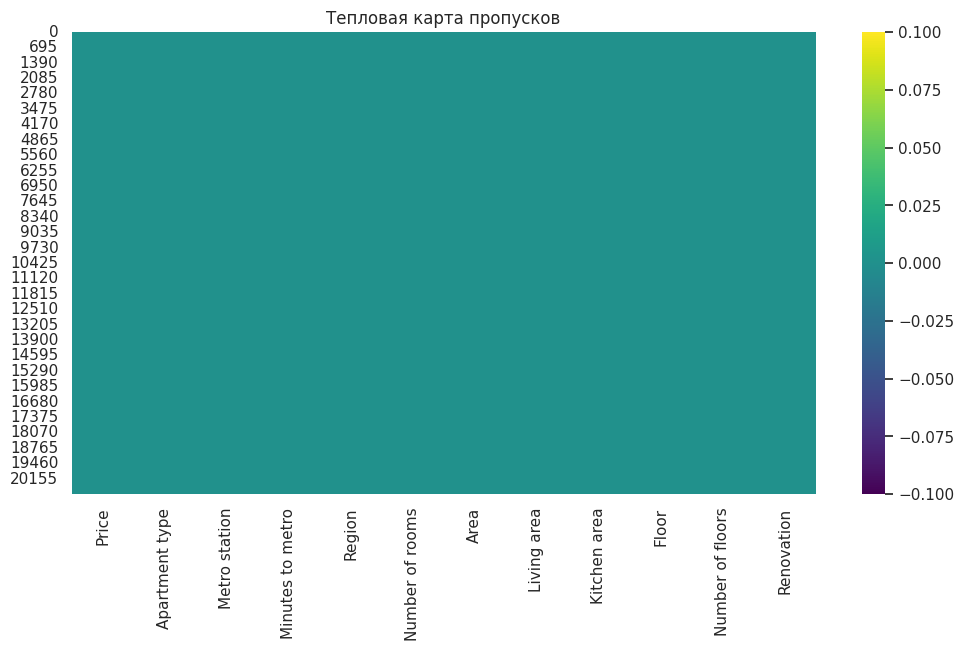

In [ ]:
sns.heatmap(data=df_moscow_flats.isna(), cmap='viridis')
plt.title('Тепловая карта пропусков')
plt.show()

In [ ]:
df_moscow_flats.head()

Price Apartment type Metro station  Minutes to metro  \
0  6300000.000000      Secondary       Опалиха          6.000000   
1  9000000.000000      Secondary       Павшино          2.000000   
2 11090000.000000      Secondary      Мякинино         14.000000   
3  8300000.000000      Secondary      Строгино          8.000000   
4  6450000.000000      Secondary       Опалиха          6.000000   

          Region  Number of rooms      Area  Living area  Kitchen area  \
0  Moscow region         1.000000 30.600000    11.100000      8.500000   
1  Moscow region         1.000000 49.200000    20.000000     10.000000   
2  Moscow region         1.000000 44.700000    16.200000     13.100000   
3  Moscow region         1.000000 35.100000    16.000000     11.000000   
4  Moscow region         1.000000 37.700000    15.200000      4.000000   

      Floor  Number of floors                 Renovation  
0 25.000000                25                   Cosmetic  
1  6.000000                15  European-style renovation  
2 10.000000                25                   Cosmetic  
3 12.000000                33  European-style renovation  
4  5.000000                 5         Without renovation

In [ ]:
df_moscow_flats.tail()

Price Apartment type  Metro station  Minutes to metro  \
20836 5884024.000000   New building     Котельники          8.000000   
20837 5900000.000000   New building  Домодедовская         25.000000   
20838 3700000.000000   New building     Котельники         30.000000   
20839 5768869.000000   New building       Жулебино         14.000000   
20840 6839157.000000   New building     Котельники          8.000000   

              Region  Number of rooms      Area  Living area  Kitchen area  \
20836  Moscow region         1.000000 44.170000    24.500000     10.300000   
20837  Moscow region         1.000000 31.600000    10.100000     12.200000   
20838  Moscow region         0.000000 18.000000    15.000000      8.100000   
20839  Moscow region         2.000000 36.390000    22.000000      6.600000   
20840  Moscow region         2.000000 56.130000    32.000000      5.000000   

          Floor  Number of floors Renovation  
20836  4.000000                17   Cosmetic  
20837 11.000000                15   Cosmetic  
20838 17.000000                17   Cosmetic  
20839 12.000000                14   Cosmetic  
20840 10.000000                17   Cosmetic

---
**Вывод:**

В данных содержится 20 841 уникальная запись, каждая из которых описана 12 столбцами: 8 количественными и 4 категориальными признаками. Пропуски в данных отсутствуют.

Анализ столбцов на основе первых и последних 5-ти записей датасета:

* **Price**: широкий диапазон значений, отражающий значительные различия в стоимости квартир.
* **Apartment type**: категориальный признак с ограниченным количеством категорий, таких как "Secondary" и "New building".
* **Metro station**: содержит большое количество категорий, представляющих различные станции метро, что может потребовать дополнительной обработки.
* **Minutes to metro**: количественный признак, представляющий количество минут до ближайшей станции метро, с диапазоном значений от 2 до 30 минут.
* **Region**: категориальный признак, характеризующий местоположение квартиры, где выделяются категории, например, "Moscow region".
* **Number of rooms**: количественный признак с небольшим диапазоном, указывающий на количество комнат в квартире, от 0 до 2 комнат в предоставленных примерах.
* **Area**: количественный признак, описывающий общую площадь квартиры, варьирующийся от 18 до 56.13 квадратных метров.
* **Living area**: количественный признак, показывающий площадь жилого пространства, варьируется от 10.1 до 32 квадратных метров.
* **Kitchen area**: количественный признак, отображающий площадь кухни, которая варьируется от 4 до 13.1 квадратных метров.
* **Floor**: количественный признак, указывающий на этаж, на котором находится квартира, от 4 до 25 этажей.
* **Number of floors**: количественный признак, показывающий количество этажей в доме, варьируется от 5 до 33 этажей.
* **Renovation**: категориальный признак, отражающий тип ремонта квартиры, с основными категориями "Cosmetic", "Without renovation", и "European-style renovation".

---

---
**Заключение:**

Данные хорошо подготовлены для дальнейшего анализа и обучения моделей, учитывая отсутствие пропусков и разнообразие признаков.

---

### Изучим описательную статистику

In [ ]:
df_moscow_flats.describe().drop("count", axis=0).T

mean             std            min  \
Price            34037767.206372 79621977.470712 1150000.000000   
Minutes to metro       11.953265        6.257113       0.000000   
Number of rooms         2.039681        1.487829       0.000000   
Area                   69.705636       64.215736       6.000000   
Living area            37.488518       35.986182       2.000000   
Kitchen area           12.421419        7.539409       1.000000   
Floor                   9.179358        7.477360       1.000000   
Number of floors       16.588072        9.608020       1.000000   

                            25%             50%             75%  \
Price            7089768.000000 11471120.000000 23550000.000000   
Minutes to metro       7.000000       11.000000       15.000000   
Number of rooms        1.000000        2.000000        3.000000   
Area                  37.160000       52.600000       75.500000   
Living area           17.500000       28.400000       43.000000   
Kitchen area           8.500000       10.600000       14.300000   
Floor                  4.000000        8.000000       13.000000   
Number of floors      11.000000       16.000000       20.000000   

                               max  
Price            2455020000.000000  
Minutes to metro         60.000000  
Number of rooms          12.000000  
Area                   1117.000000  
Living area             566.800000  
Kitchen area            122.000000  
Floor                    92.000000  
Number of floors         97.000000

In [ ]:
df_moscow_flats.describe(include='object').drop("count", axis=0).T

unique                top   freq
Apartment type      2          Secondary  12227
Metro station     547  Красногвардейская   2417
Region              2             Moscow  14773
Renovation          4           Cosmetic  11806

---
**Вывод:**

Анализ описательной статистики данных показывает следующее:

* **Price**: Средняя цена квартиры составляет 34 037 767 рублей, однако стандартное отклонение (79 621 977) и максимальное значение (2 455 020 000) указывают на наличие очень дорогих объектов. Это может свидетельствовать о существенных выбросах. Медиана в 11 471 120 рублей лучше отражает типичные цены на квартиры.

* **Minutes to metro**: Среднее время до ближайшей станции метро составляет 11.95 минут, что близко к медианному значению 11 минут. Диапазон варьируется от квартир, расположенных непосредственно возле метро (0 минут), до удаленных на 60 минут ходьбы.

* **Number of rooms**: В среднем квартиры имеют 2 комнаты. Однако есть квартиры с нулевым количеством комнат (студии) и редкие объекты с 12 комнатами. 75% квартир имеют до 3 комнат, что типично для жилья.

* **Area**: Средняя общая площадь квартиры - 69.7 м², при этом стандартное отклонение указывает на значительную вариативность, особенно с учётом максимальной площади в 1 117 м². Медианное значение в 52.6 м² показывает, что типичная квартира имеет более скромные размеры.

* **Living area**: Жилая площадь в среднем составляет 37.5 м², а медиана - 28.4 м². В данных присутствуют объекты с очень большой жилой площадью (до 566.8 м²), что, вероятно, относится к элитным или многоуровневым квартирам.

* **Kitchen area**: Средняя площадь кухни составляет 12.4 м², а медиана - 10.6 м². Однако наблюдаются выбросы, например, квартиры с кухнями до 122 м².

* **Floor**: Медианный этаж - 8. Максимум достигает 92 этажа, что предполагает наличие высокоэтажных зданий или небоскрёбов.

* **Number of floors**: В среднем здания имеют 16.6 этажей (округляя в большую сторону, 17 этажей), что указывает на преимущественное распространение многоэтажек. Максимум в 97 этажей снова говорит о присутствии небоскрёбов.

Категориальные признаки:

* **Apartment type**: В датасете доминируют квартиры вторичного рынка ("Secondary"), что составляет около 12 227 записей. Бинарный столбец.
* **Metro station**: Присутствует 547 уникальных станций метро, среди которых наиболее часто встречается "Красногвардейская" (2 417 записей).
* **Region**: Преобладающая часть данных приходится на Москву (14 773 записи). Бинарный столбец.
* **Renovation**: Самым частым типом ремонта является "Cosmetic" - 11 806 объектов. Всего 4 категории.

---

## EDA + ответы на вопросы

### 1. Какие типы квартир наиболее распространены в регионе?

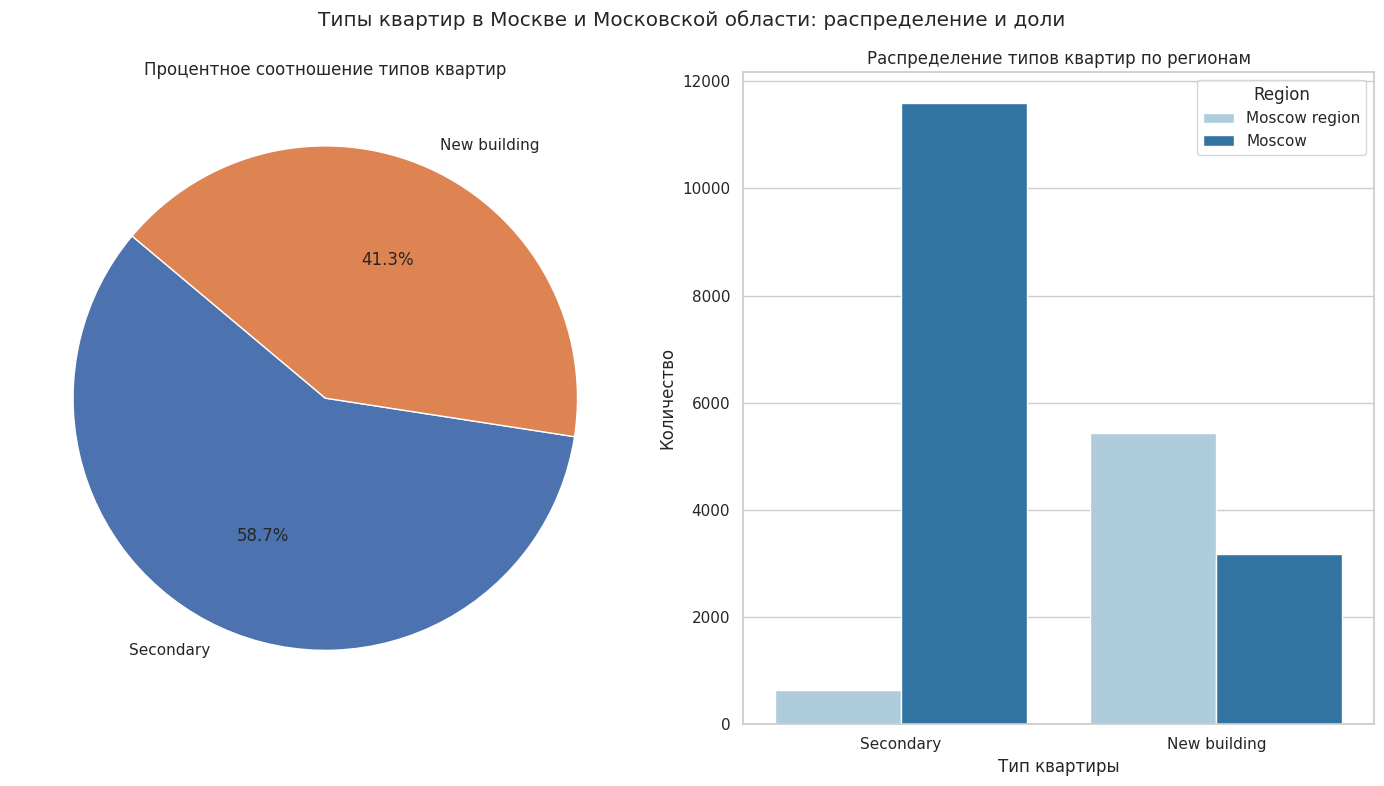

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), dpi=100, tight_layout=True)

sns.countplot(data=df_moscow_flats, x='Apartment type', hue='Region', ax=axes[1], palette="Paired")
axes[1].set_xlabel("Тип квартиры")
axes[1].set_ylabel('Количество')
axes[1].set_title("Распределение типов квартир по регионам")

apartment_counts = df_moscow_flats['Apartment type'].value_counts()
labels = apartment_counts.index
sizes = apartment_counts.values

axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Процентное соотношение типов квартир")

plt.suptitle("Типы квартир в Москве и Московской области: распределение и доли")
plt.show()

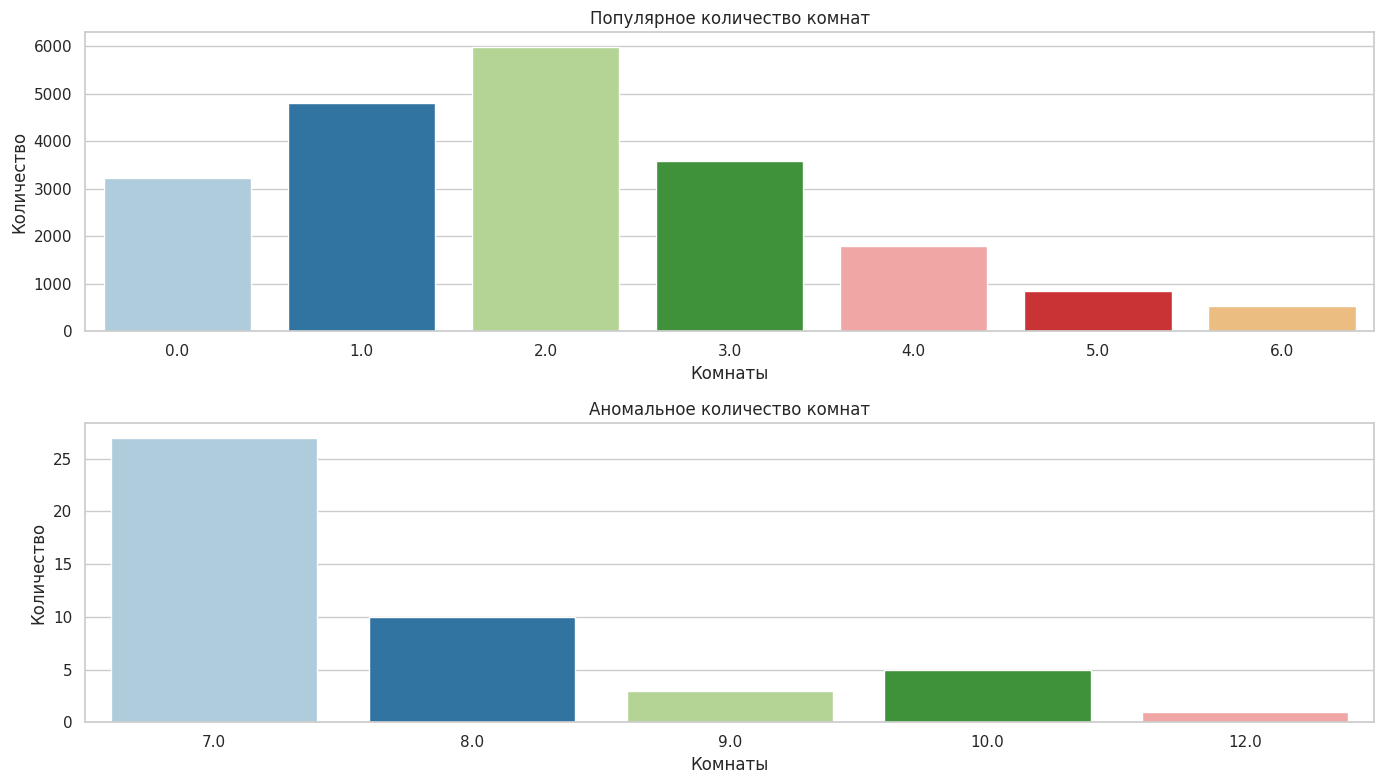

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), dpi=100, tight_layout=True)

sns.countplot(data=df_moscow_flats[df_moscow_flats['Number of rooms'] < 7], x='Number of rooms', hue='Number of rooms', legend=False, palette="Paired", ax=axes[0])
axes[0].set_xlabel("Комнаты")
axes[0].set_ylabel("Количество")
axes[0].set_title("Популярное количество комнат")

sns.countplot(data=df_moscow_flats[df_moscow_flats['Number of rooms'] >= 7], x='Number of rooms', hue='Number of rooms', legend=False, palette="Paired", ax=axes[1])
axes[1].set_xlabel("Комнаты")
axes[1].set_ylabel("Количество")
axes[1].set_title("Аномальное количество комнат")

plt.show()

---
**Информация по графику:**

1. **Распределение типов квартир:**
    * *В процентном соотношении:*
        * Secondary (вторичное жилье) составляет 58.7% от всех квартир.
        * New building (новостройки) - 41.3%.
    * *Распределение по регионам:*
        * В Москве основная доля квартир относится к категории Secondary (вторичное жилье).
        * В Московской области также присутствует значительное количество квартир категории Secondary, но в отличие от Москвы, здесь новостройки составляют более значимую долю.

2. **Популярное количество комнат:**
    * *Наиболее популярные варианты:*
        * 2-комнатные квартиры являются самыми распространенными, их количество превышает 6000.
        * 1-комнатные и 3-комнатные квартиры также занимают значительную долю рынка.
        * Меньше всего представлено 5 и 6-комнатных квартир.
3. **Аномальное количество комнат:**
    * *Присутствуют редкие варианты с большим количеством комнат:*
        * Самое необычное количество комнат - 7, таких квартир насчитывается около 25.
        * Также есть квартиры с 8, 9, 10 и даже 12 комнатами, но их количество крайне мало.

---

---
**Вывод:**

Вторичное жилье является наиболее распространенным типом квартир как в Москве, так и в Московской области, занимая более половины предложений. Основная масса квартир имеет от 1 до 3 комнат, что типично для большинства предложений на рынке. Квартиры с аномально большим количеством комнат (7 и более) встречаются крайне редко и являются исключениями.

---

### 2. Существует ли связь между ценами на жилье и близостью к станциям метро?

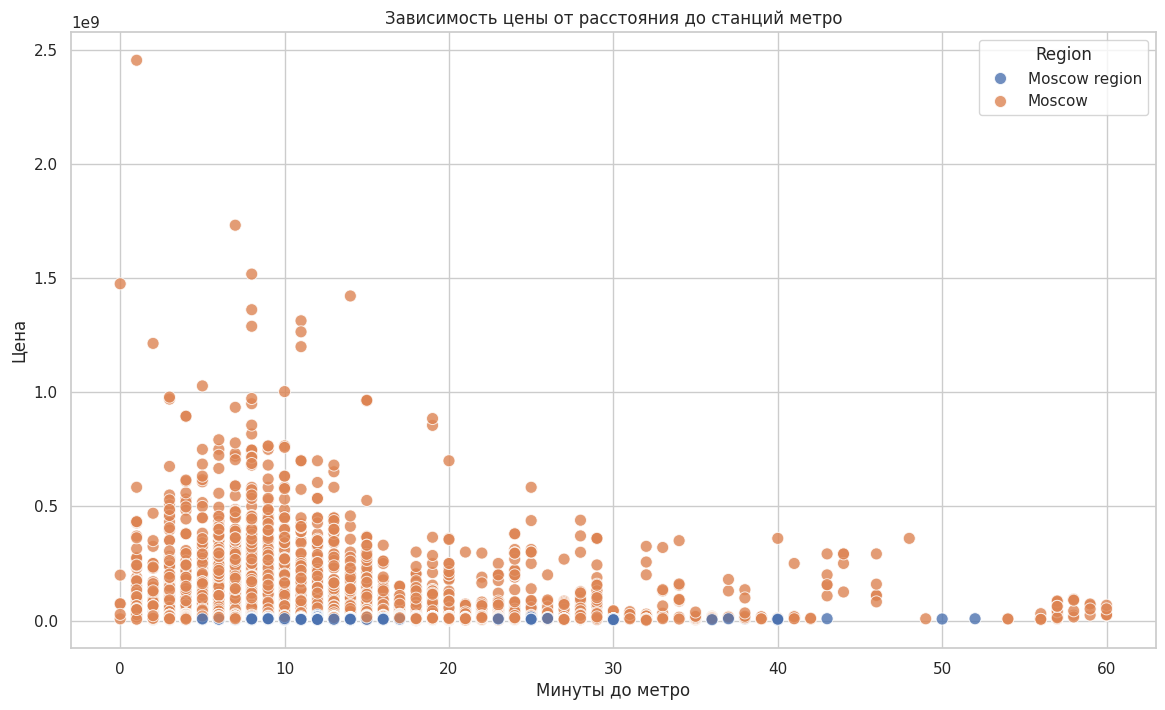

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.scatterplot(data=df_moscow_flats, x='Minutes to metro', y='Price', hue='Region', s=75, alpha=0.8)
plt.xlabel("Минуты до метро")
plt.ylabel("Цена")
plt.title('Зависимость цены от расстояния до станций метро')
plt.show()

In [ ]:
df_moscow_flats.select_dtypes(exclude='object').corr().loc['Price', 'Minutes to metro']

-0.09350090233129069

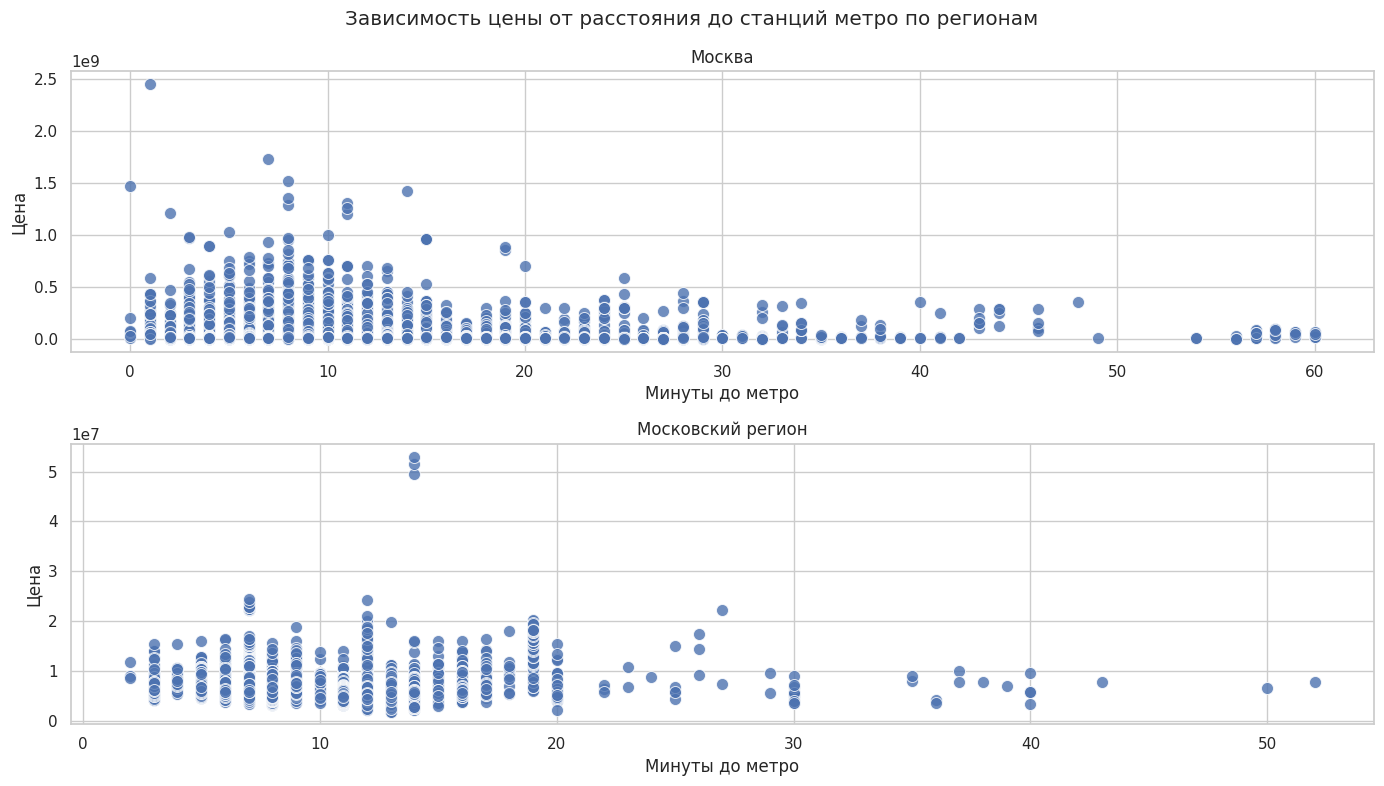

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), dpi=100, tight_layout=True)

sns.scatterplot(data=df_moscow_flats[df_moscow_flats['Region'] == 'Moscow'], x='Minutes to metro', y='Price', s=75, alpha=0.8, ax=axes[0])
axes[0].set_xlabel("Минуты до метро")
axes[0].set_ylabel("Цена")
axes[0].set_title("Москва")

sns.scatterplot(data=df_moscow_flats[df_moscow_flats['Region'] == 'Moscow region'], x='Minutes to metro', y='Price', s=75, alpha=0.8, ax=axes[1])
axes[1].set_xlabel("Минуты до метро")
axes[1].set_ylabel("Цена")
axes[1].set_title("Московский регион")

plt.suptitle('Зависимость цены от расстояния до станций метро по регионам')
plt.show()

In [ ]:
df_moscow_flats[df_moscow_flats['Region'] == 'Moscow'].select_dtypes(exclude='object').corr().loc['Price', 'Minutes to metro']

-0.14112349371422708

In [ ]:
df_moscow_flats[df_moscow_flats['Region'] == 'Moscow region'].select_dtypes(exclude='object').corr().loc['Price', 'Minutes to metro']

-0.12931319376410075

---
**Информация по графику:**

1. **Москва:**
    * Можно наблюдать, что жилье ближе к метро (в пределах 10-15 минут) зачастую дороже.
    * Есть выбросы (например, несколько объектов с очень высокой стоимостью, превышающей 1 млрд рублей), но в среднем цены стабилизируются в диапазоне от 0 до 50 миллионов рублей на расстояниях до 30 минут пешком от метро.
    * Цены на жилье, расположенное дальше 20-30 минут от метро, начинают снижаться, хотя по-прежнему встречаются отдельные дорогие объекты.

2. **Московский регион:**
    * Цены на жилье в Московской области, как правило, значительно ниже, чем в Москве, с максимумами в районе 50 миллионов рублей.
    * Вблизи метро (до 10 минут) можно заметить небольшое повышение цен, но оно не столь явное, как в Москве.
    * Чем дальше от метро, тем меньше объектов с высокими ценами, особенно на расстояниях более 20-30 минут.

---

---
**Вывод:**

* В Москве связь между ценой жилья и расстоянием до метро более выражена, хотя и остаётся слабо выраженной: чем ближе к метро, тем дороже объекты.
* В Московской области влияние метро на стоимость жилья ещё слабее, хотя цены также несколько снижаются с увеличением расстояния до метро.
* Отрицательные коэффициенты корреляции, приближенные к нулю, также сигнализируют об отсутствии зависимости.

---

### 3. Как уровень ремонта влияет на цену квартиры?

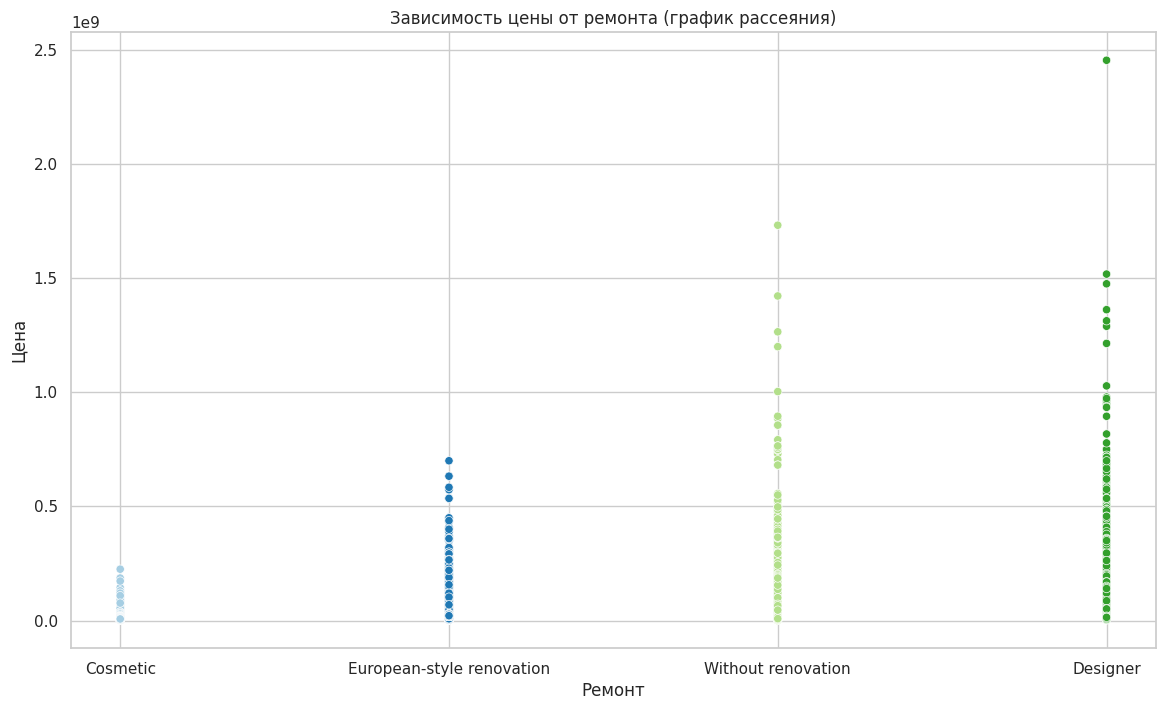

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.scatterplot(data=df_moscow_flats, x='Renovation', y='Price', hue='Renovation', legend=False, palette="Paired")
plt.xlabel("Ремонт")
plt.ylabel("Цена")
plt.title("Зависимость цены от ремонта (график рассеяния)")
plt.show()

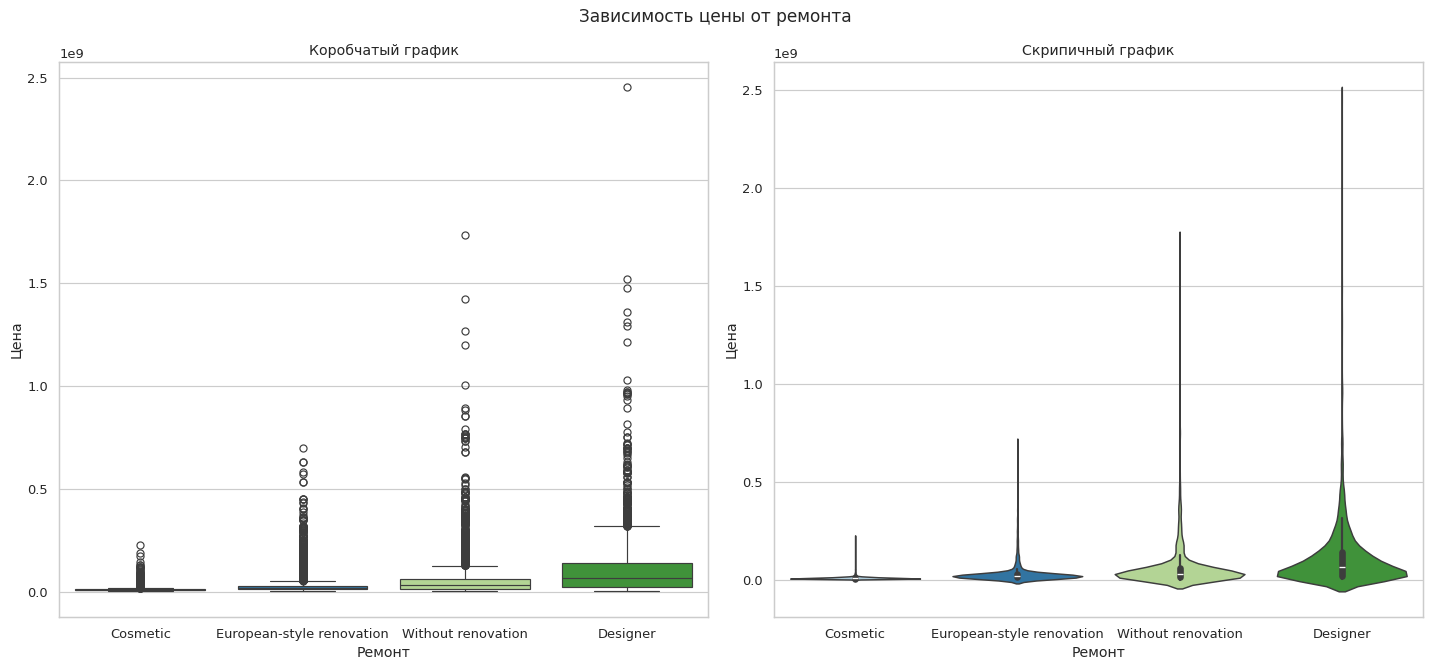

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 8), dpi=85, tight_layout=True)

sns.boxplot(data=df_moscow_flats, x='Renovation', y='Price', hue='Renovation', legend=False, palette="Paired", ax=axes[0])
axes[0].set_xlabel("Ремонт")
axes[0].set_ylabel("Цена")
axes[0].set_title("Коробчатый график")

sns.violinplot(data=df_moscow_flats, x='Renovation', y='Price', hue='Renovation', legend=False, palette="Paired", ax=axes[1])
axes[1].set_xlabel("Ремонт")
axes[1].set_ylabel("Цена")
axes[1].set_title("Скрипичный график")

plt.suptitle("Зависимость цены от ремонта")
plt.show()

---
**Информация по графикам:**

1. **График рассеяния:**
    * Самый низкий уровень цен наблюдается у квартир с косметическим ремонтом.
    * Квартиры с евро-ремонтом (European-style renovation) находятся в диапазоне более высоких цен, но основная масса сосредоточена до 500 миллионов.
    * Квартиры без ремонта (Without renovation) имеют более широкий диапазон цен, чем косметический и евро-ремонт, но также сосредоточены в нижней части.
    * Самые высокие цены характерны для квартир с дизайнерским ремонтом, причём присутствует несколько точек, которые выходят далеко за 2 миллиарда.

2. **Коробчатый график (Boxplot):**
    * Косметический ремонт и квартиры без ремонта имеют схожие низкие медианы цены, с небольшим количеством выбросов.
    * Евро-ремонт показывает чуть более высокий уровень цен, но без значительных выбросов.
    * Дизайнерский ремонт явно выделяется: квартиры с таким типом ремонта имеют как высокие медианы, так и большое количество высоких выбросов, что говорит о значительных отличиях в цене.

3. **Скрипичный график (Violin Plot):**
    * Данные подтверждают предыдущие выводы, показывая, что в основном цены на квартиры с косметическим ремонтом и без ремонта сосредоточены в низком диапазоне.
    * Для евро-ремонта цены более распределены, но основная масса все же находится в нижней части.
    * Дизайнерский ремонт имеет наибольший диапазон цен с высокой концентрацией как в нижней, так и верхней части.

---

---
**Вывод:**

Наблюдается положительная зависимость между уровнем ремонта и ценой квартиры. Чем лучше и сложнее ремонт (например, дизайнерский), тем выше цена.

---

### 4. Есть ли разница в ценах на жилье между Москвой и Московской областью?

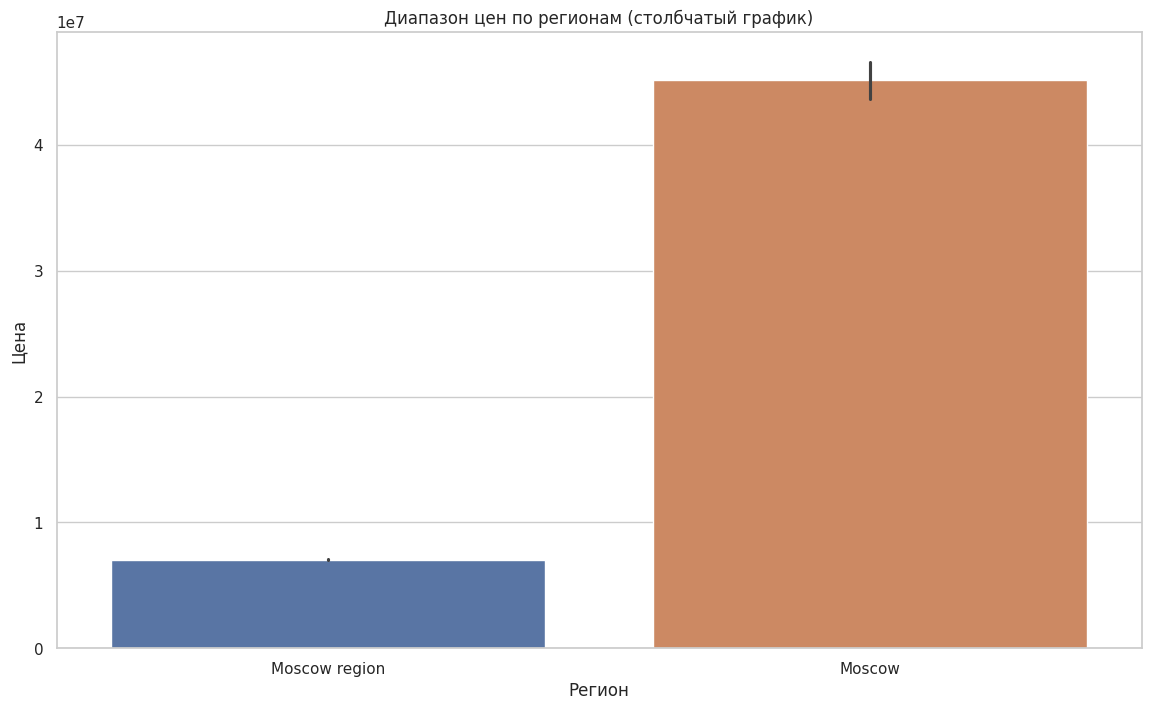

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.barplot(data=df_moscow_flats, x='Region', y='Price', hue='Region', legend=False)
plt.xlabel("Регион")
plt.ylabel("Цена")
plt.title("Диапазон цен по регионам (столбчатый график)")
plt.show()

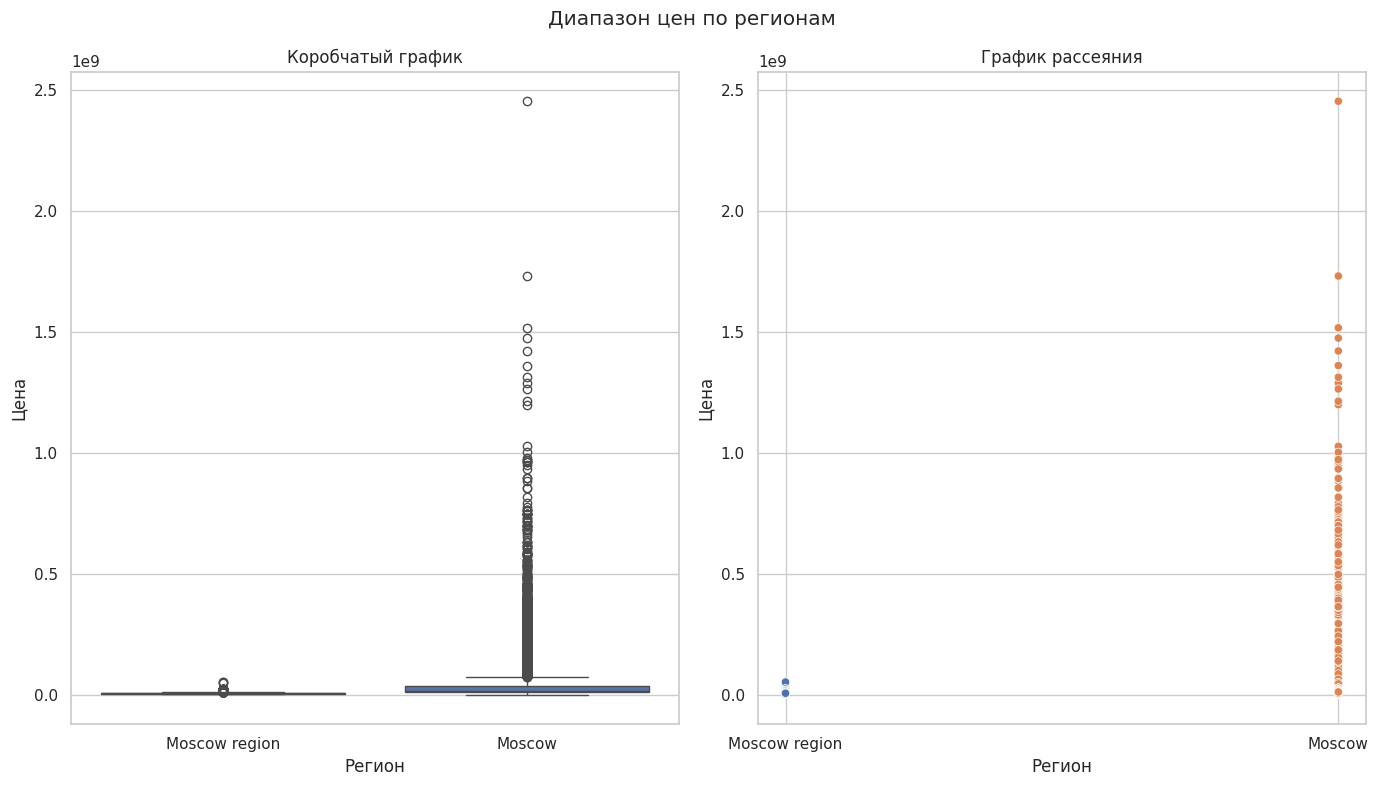

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), dpi=100, tight_layout=True)

sns.boxplot(data=df_moscow_flats, x='Region', y='Price', ax=axes[0])
axes[0].set_xlabel("Регион")
axes[0].set_ylabel("Цена")
axes[0].set_title("Коробчатый график")

sns.scatterplot(data=df_moscow_flats, x='Region', y='Price', hue='Region', legend=False, ax=axes[1])
axes[1].set_xlabel("Регион")
axes[1].set_ylabel("Цена")
axes[1].set_title("График рассеяния")

plt.suptitle('Диапазон цен по регионам')
plt.show()

---
**Информация по графикам:**

1. **Столбчатый график:**
    * Москва значительно превосходит Московскую область по уровню цен. Средние значения цен в Москве значительно выше (около 4x по сравнению с Московской областью).
    * Столбчатый график демонстрирует явную разницу в среднем ценовом диапазоне между регионами.

2. **Коробчатый график по регионам:**
    * **Москва:** Большое количество выбросов (значения, значительно превышающие остальные). Основная часть данных сосредоточена ближе к нулю, но присутствуют ценовые всплески выше 1 и даже 2 миллиардов.
    * **Московская область:** Цены ниже, чем в Москве. Есть несколько незначительных выбросов, но они гораздо меньше в сравнении с Москвой.

3. **График рассеяния:**
    * Подтверждает наблюдения с коробчатого графика. В Москве наблюдаются высокие разбросы цен с множеством точек на высоких значениях, что показывает большую вариативность цен.
    * В Московской области большинство значений сконцентрированы в нижней части, что указывает на более узкий диапазон цен.

---

---
**Вывод:**

Оба типа графиков подтверждают, что цены на жилье в Москве значительно выше, чем в Московской области.

---

### 5. Есть ли какие-либо предпочтения относительно уровня этажа?

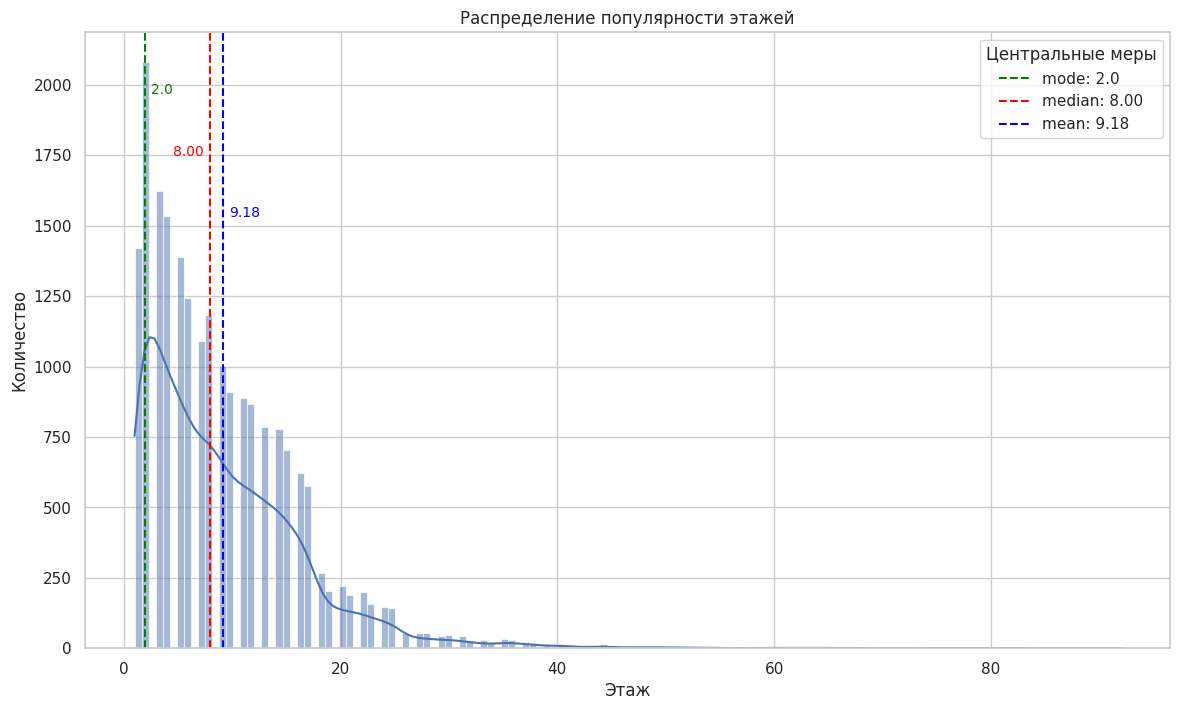

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.histplot(data=df_moscow_flats['Floor'], kde=True)

mode_value = df_moscow_flats['Floor'].mode().iloc[0]
median_value = df_moscow_flats['Floor'].median()
mean_value = df_moscow_flats['Floor'].mean()

plt.axvline(x=mode_value, color='green', ls='--', label=f'mode: {mode_value}')
plt.axvline(x=median_value, color='red', ls='--', label=f'median: {median_value:.2f}')
plt.axvline(x=mean_value, color='blue', ls='--', label=f'mean: {mean_value:.2f}')

plt.text(mode_value + 0.5, plt.ylim()[1]*0.9, f'{mode_value}', color='green', fontsize=10)
plt.text(median_value - 3.5, plt.ylim()[1]*0.8, f'{median_value:.2f}', color='red', fontsize=10)
plt.text(mean_value + 0.5, plt.ylim()[1]*0.7, f'{mean_value:.2f}', color='blue', fontsize=10)

plt.xlabel("Этаж")
plt.ylabel("Количество")
plt.title("Распределение популярности этажей")
plt.legend(title='Центральные меры')
plt.show()

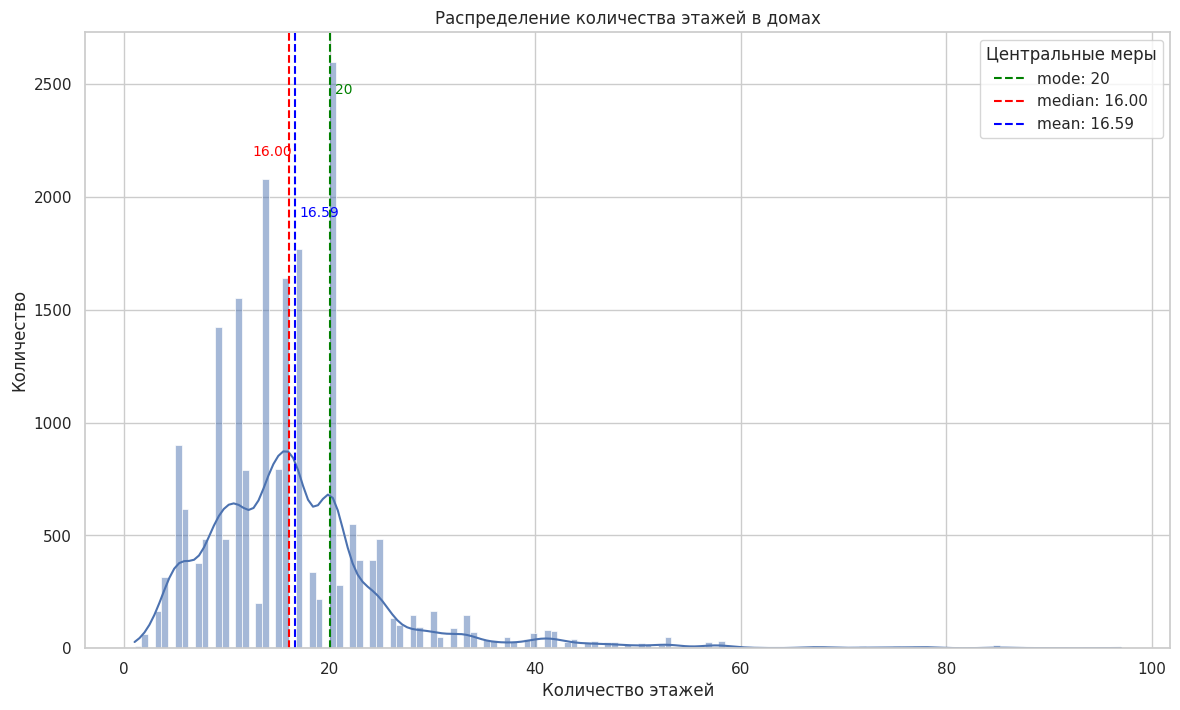

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.histplot(data=df_moscow_flats, x='Number of floors', kde=True)

mode_value = df_moscow_flats['Number of floors'].mode().iloc[0]
median_value = df_moscow_flats['Number of floors'].median()
mean_value = df_moscow_flats['Number of floors'].mean()

plt.axvline(x=mode_value, color='green', ls='--', label=f'mode: {mode_value}')
plt.axvline(x=median_value, color='red', ls='--', label=f'median: {median_value:.2f}')
plt.axvline(x=mean_value, color='blue', ls='--', label=f'mean: {mean_value:.2f}')

plt.text(mode_value + 0.5, plt.ylim()[1]*0.9, f'{mode_value}', color='green', fontsize=10)
plt.text(median_value - 3.5, plt.ylim()[1]*0.8, f'{median_value:.2f}', color='red', fontsize=10)
plt.text(mean_value + 0.5, plt.ylim()[1]*0.7, f'{mean_value:.2f}', color='blue', fontsize=10)

plt.xlabel("Количество этажей")
plt.ylabel("Количество")
plt.title("Распределение количества этажей в домах")
plt.legend(title='Центральные меры')
plt.show()

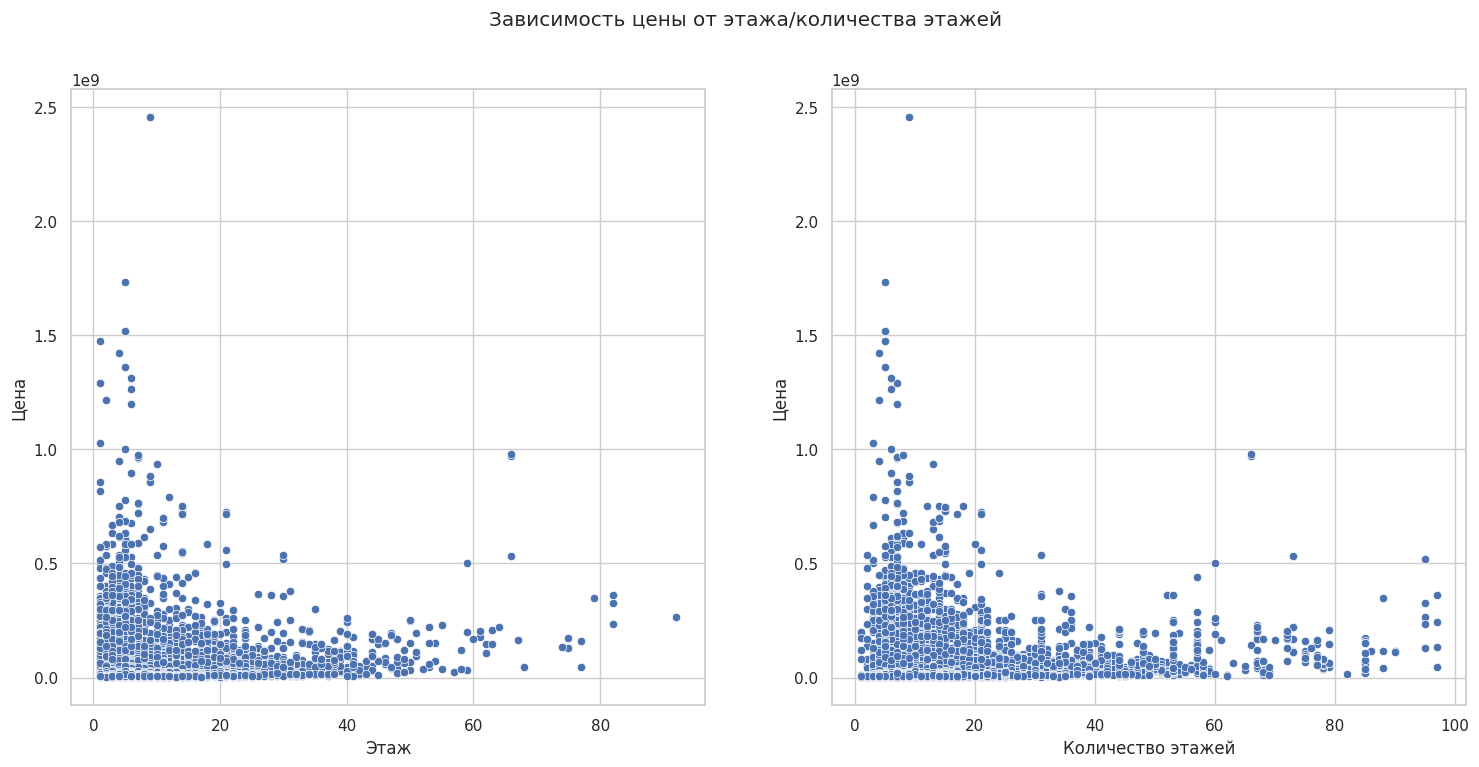

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), dpi=100)

sns.scatterplot(data=df_moscow_flats, x='Floor', y='Price', ax=axes[0])
axes[0].set_xlabel("Этаж")
axes[0].set_ylabel("Цена")

sns.scatterplot(data=df_moscow_flats, x='Number of floors', y='Price', ax=axes[1])
axes[1].set_xlabel("Количество этажей")
axes[1].set_ylabel("Цена")

plt.suptitle("Зависимость цены от этажа/количества этажей")
plt.show()

---
**Вывод:**

Наиболее предпочтительным этажом является 2-ой этаж. Большинство людей стремятся к покупке высокоэтажных домов. На основе первом графике рассеяния можно заметить, что 1-10 этажи имеют более широкий диапазон цен, нежели остальные.

Может показаться странным, что дома с 1-10 этажами имеют больший диапазон цен в сравнении с домами-высокоэтажками (20-50 этажей), диапазон цен у которых значительно ниже.

---

---
**Почему?**

Почему дома с 1-10 этажами имеют больший диапазон цен в сравнении с домами-высокоэтажками (20-50 этажей), диапазон цен у которых значительно ниже?

**Предположения:**

1. **Тип недвижимости и престиж района:**
    * Низкоэтажные дома часто относятся к элитной или премиальной недвижимости, особенно если они расположены в центральных или престижных районах. Это могут быть дома с улучшенной планировкой, высокими потолками и малыми плотностями застройки, что существенно увеличивает стоимость жилья.
    * Высокоэтажные дома чаще ассоциируются с массовым жильем (особенно новостройки в пригородах и спальных районах), где на рынке преобладают квартиры эконом-класса или бизнес-класса, но в меньшей степени премиум.

2. **Комфорт и приватность:**
    * В низкоэтажных домах обычно меньше квартир, что создает ощущение большей приватности и комфорта. Жителям обеспечивается более спокойная атмосфера и личное пространство. Это также способствует увеличению цены.
    * В высотках, наоборот, плотность жильцов выше, что приводит к меньшей приватности, большим очередям на лифты и, возможно, шуму и дискомфорту. Это может снижать ценность таких объектов, особенно для тех, кто ищет уединение.

3. **Развитость инфраструктуры и окружение:**
    * Низкоэтажные дома могут располагаться в более старых, обжитых районах с развитой инфраструктурой, зелеными зонами и удобным транспортом. Это добавляет ценности таким объектам.
    * Высотные дома чаще строятся в рамках крупных застроек, в которых инфраструктура может быть развита хуже (особенно в новых районах), что тоже сказывается на цене.

4. **Стоимость строительства и спрос:**
    * Строительство высотных домов обходится дешевле за счет массового застройки и большего количества квартир. В связи с этим такие дома могут предложить более широкий ассортимент доступных по цене квартир.
    * В низкоэтажных домах зачастую используются более дорогие материалы и архитектурные решения, что увеличивает себестоимость, и как следствие, цену.

5. **Престижность видов и места:**
    * В высотных домах видовые квартиры (с верхних этажей) могут стоить дороже, но большая часть квартир на средних и низких этажах продается по более доступным ценам.
    * В низкоэтажных домах каждый объект может иметь уникальные особенности (собственный сад, терраса и пр.), что делает их более дорогими.


---

### Несколько других не менее интересных графиков

#### Распределение цен

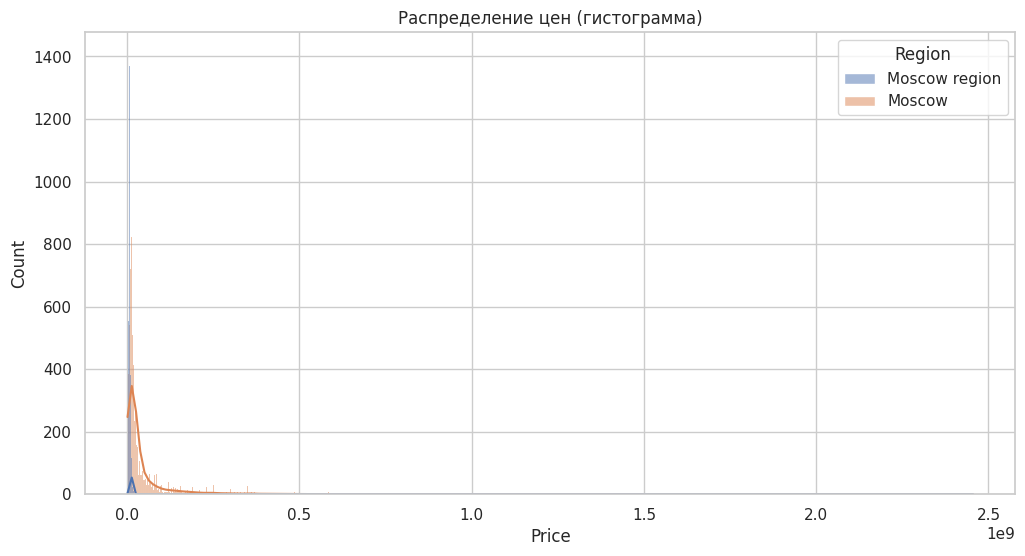

In [ ]:
sns.histplot(data=df_moscow_flats, x='Price', kde=True, hue='Region')
plt.title("Распределение цен (гистограмма)")
plt.show()

In [ ]:
df_city_moscow_flats = df_moscow_flats[df_moscow_flats['Region'] == 'Moscow']
df_reg_moscow_flats = df_moscow_flats[df_moscow_flats['Region'] != 'Moscow']

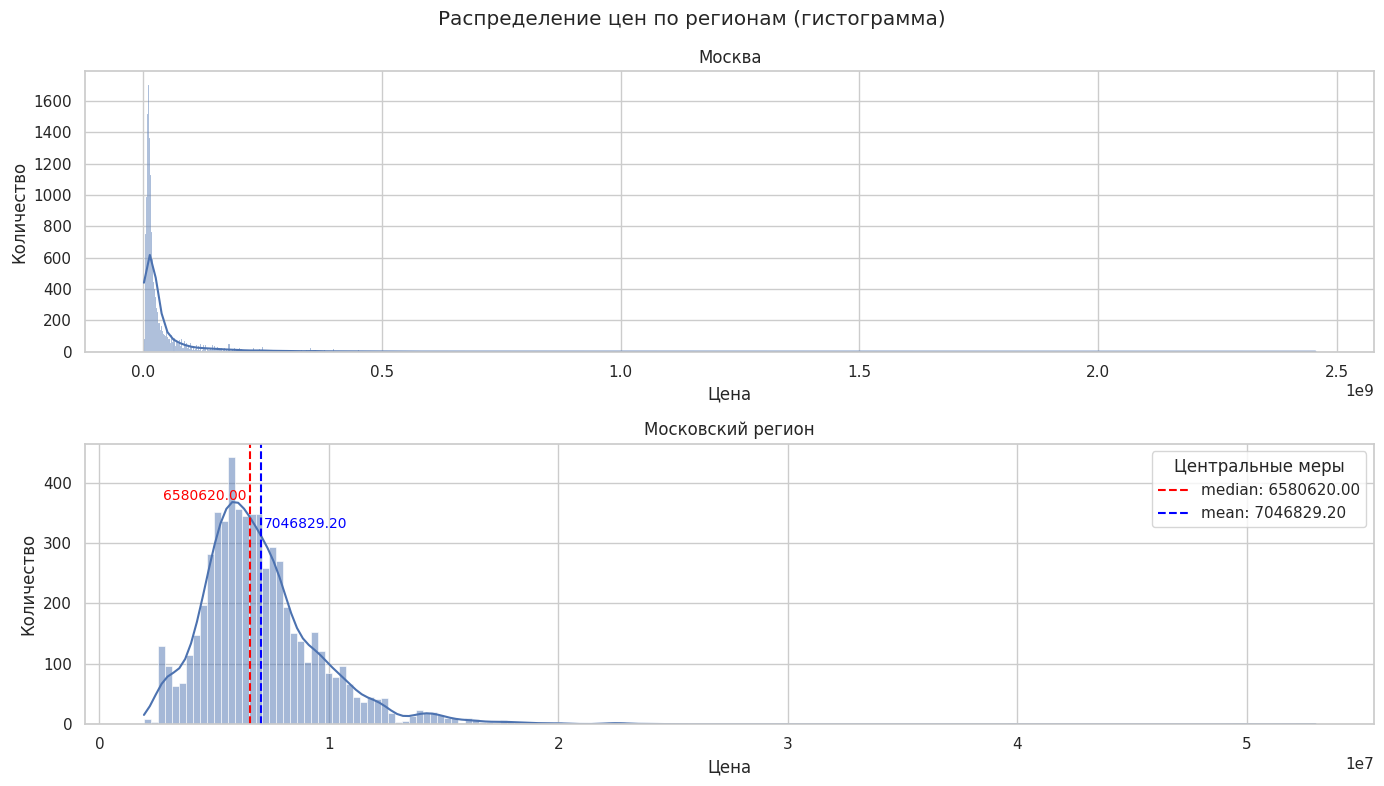

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), dpi=100, tight_layout=True)

sns.histplot(data=df_city_moscow_flats, x='Price', kde=True, ax=axes[0])
axes[0].set_xlabel("Цена")
axes[0].set_ylabel("Количество")
axes[0].set_title("Москва")

sns.histplot(data=df_reg_moscow_flats, x='Price', kde=True, ax=axes[1])
axes[1].set_xlabel("Цена")
axes[1].set_ylabel("Количество")
axes[1].set_title("Московский регион")

median_value = df_reg_moscow_flats['Price'].median()
mean_value = df_reg_moscow_flats['Price'].mean()

plt.axvline(x=median_value, color='red', ls='--', label=f'median: {median_value:.2f}')
plt.axvline(x=mean_value, color='blue', ls='--', label=f'mean: {mean_value:.2f}')

plt.text(median_value - 3_800_000, plt.ylim()[1]*0.8, f'{median_value:.2f}', color='red', fontsize=10)
plt.text(mean_value + 100_000, plt.ylim()[1]*0.7, f'{mean_value:.2f}', color='blue', fontsize=10)

plt.legend(title='Центральные меры')
plt.suptitle("Распределение цен по регионам (гистограмма)")
plt.show()

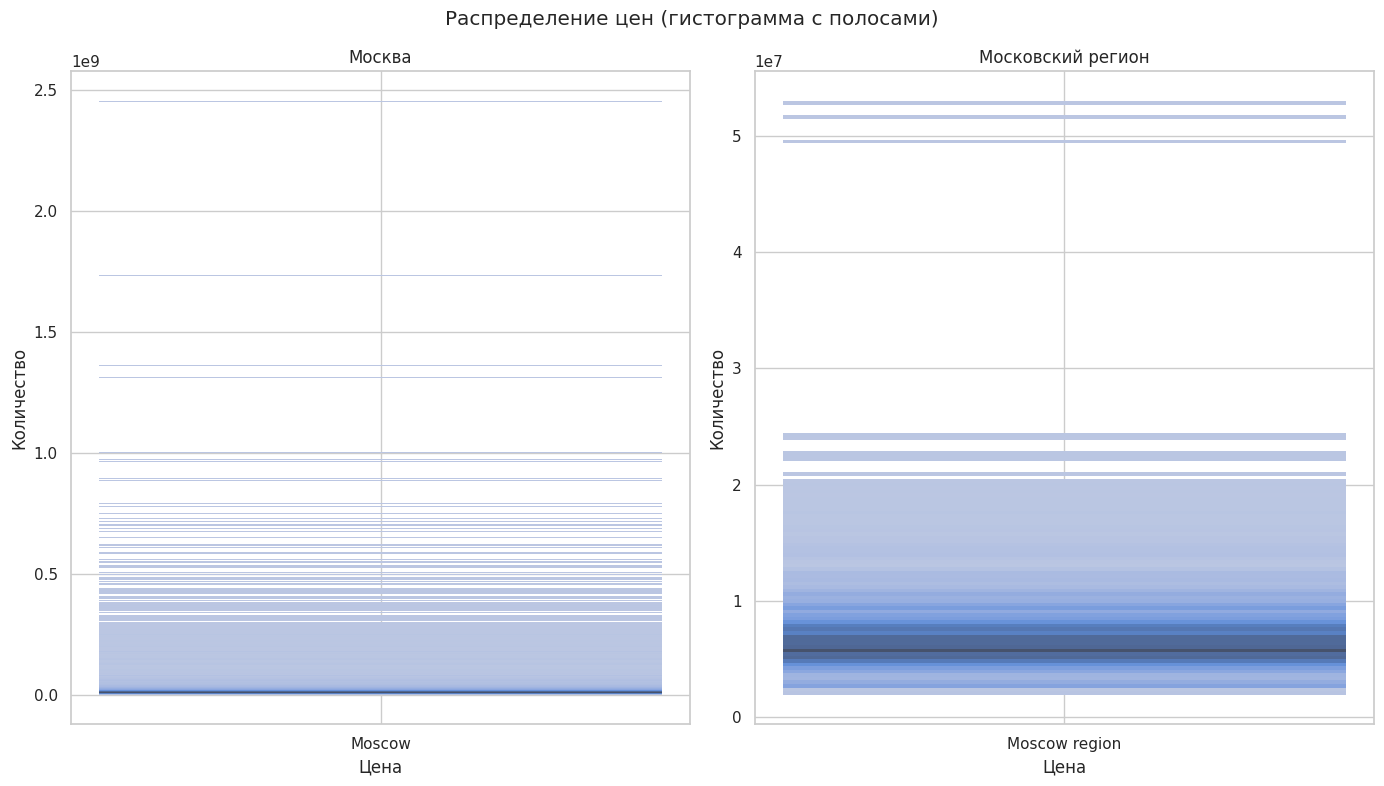

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), dpi=100, tight_layout=True)

sns.histplot(data=df_city_moscow_flats, y='Price', x='Region', ax=axes[0])
axes[0].set_xlabel("Цена")
axes[0].set_ylabel("Количество")
axes[0].set_title("Москва")

sns.histplot(data=df_reg_moscow_flats, y='Price', x='Region', ax=axes[1])
axes[1].set_xlabel("Цена")
axes[1].set_ylabel("Количество")
axes[1].set_title("Московский регион")

plt.suptitle("Распределение цен (гистограмма с полосами)")
plt.show()

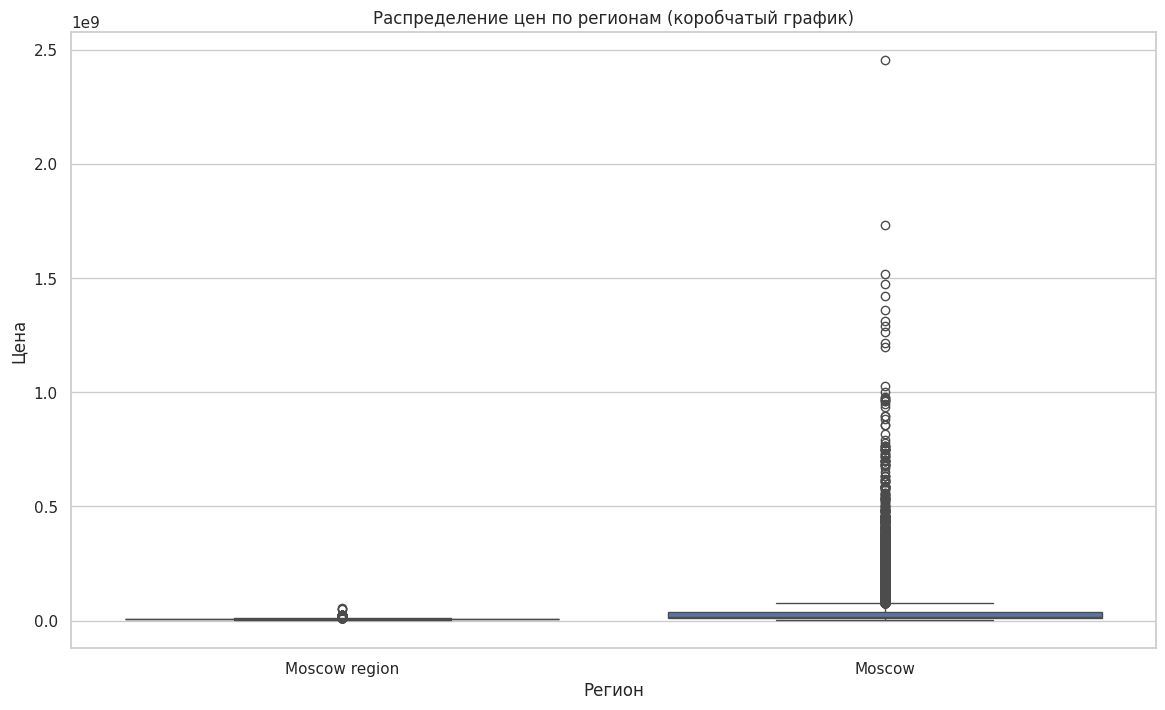

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.boxplot(data=df_moscow_flats, x='Region', y='Price')
plt.xlabel("Регион")
plt.ylabel("Цена")

plt.title("Распределение цен по регионам (коробчатый график)")
plt.show()

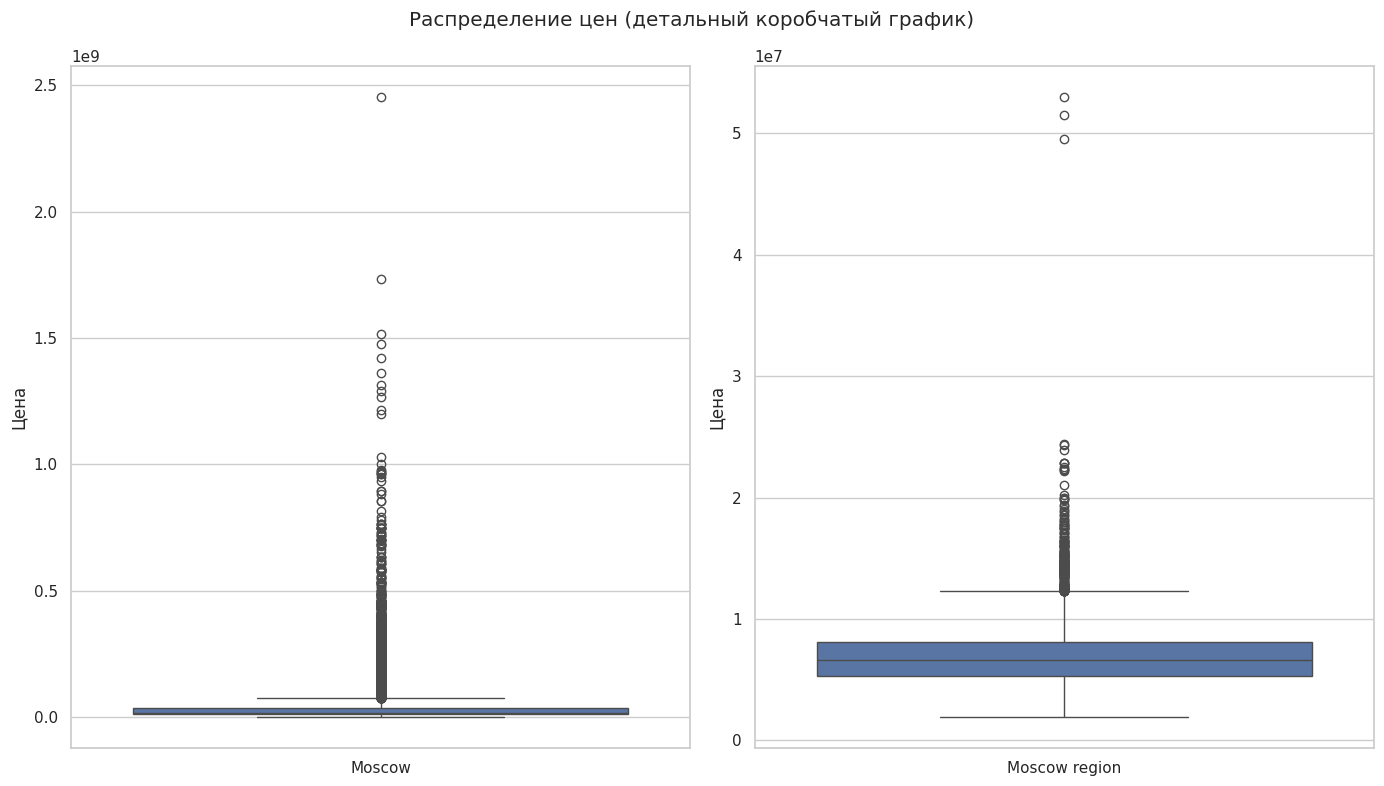

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), dpi=100, tight_layout=True)

sns.boxplot(data=df_city_moscow_flats, y='Price', x='Region', ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_ylabel("Цена")

sns.boxplot(data=df_reg_moscow_flats, y='Price', x='Region', ax=axes[1])
axes[1].set_xlabel("")
axes[1].set_ylabel("Цена")

plt.suptitle("Распределение цен (детальный коробчатый график)")
plt.show()

---
**Вывод:**

Цена на жилье в Московском регионе значительно ниже и имеет более низкий диапазон, нежели цена на жилье в Москве.

---

#### Зависимость цены от общей площади

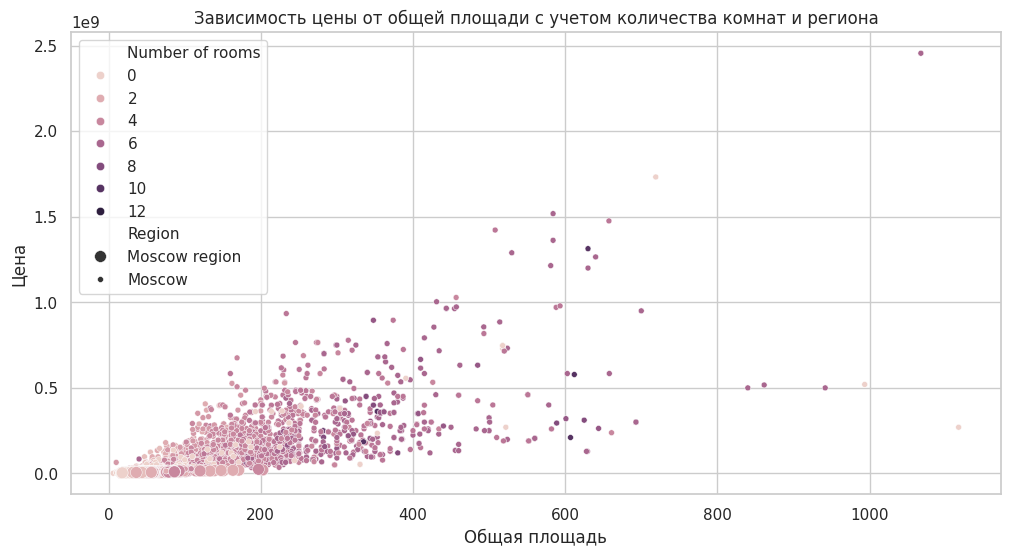

In [ ]:
sns.scatterplot(data=df_moscow_flats, x='Area', y='Price', hue='Number of rooms', size='Region')
plt.xlabel("Общая площадь")
plt.ylabel("Цена")
plt.title("Зависимость цены от общей площади с учетом количества комнат и региона")
plt.show()

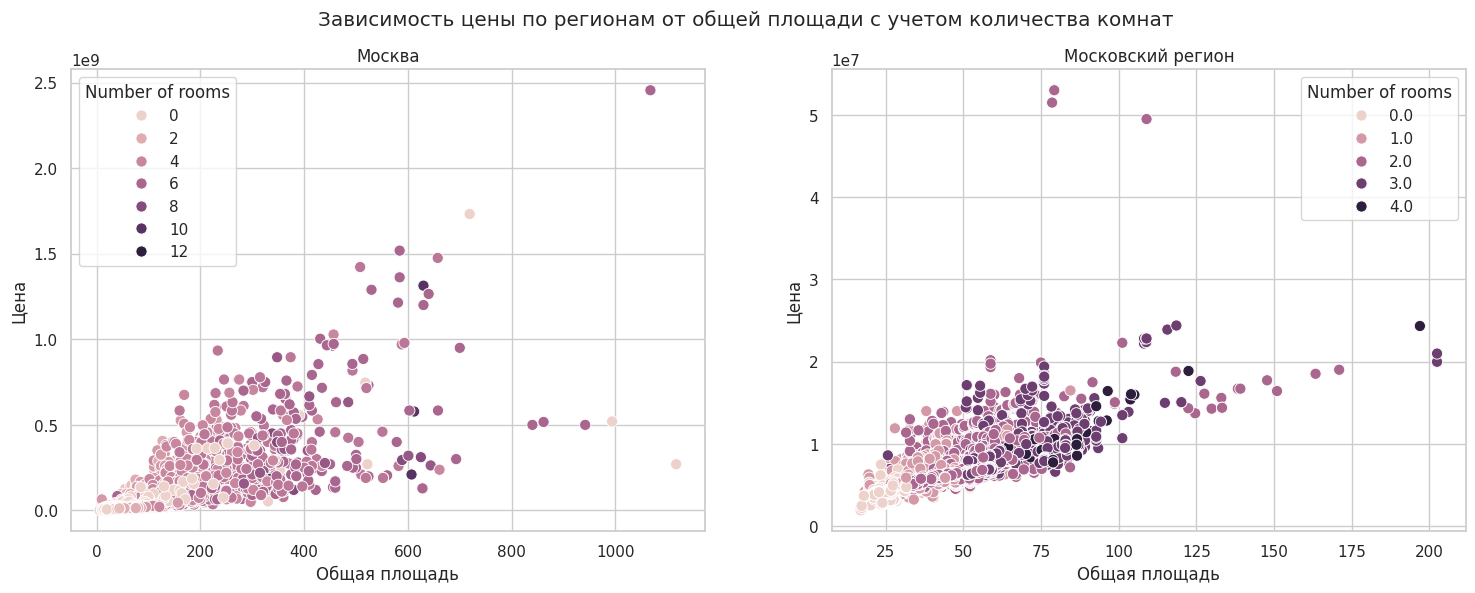

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(data=df_city_moscow_flats, x='Area', y='Price', s=65, hue='Number of rooms', ax=axes[0])
axes[0].set_xlabel("Общая площадь")
axes[0].set_ylabel("Цена")
axes[0].set_title("Москва")

sns.scatterplot(data=df_reg_moscow_flats, x='Area', y='Price', s=65, hue='Number of rooms', ax=axes[1])
axes[1].set_xlabel("Общая площадь")
axes[1].set_ylabel("Цена")
axes[1].set_title("Московский регион")

plt.suptitle("Зависимость цены по регионам от общей площади с учетом количества комнат")
plt.show()

---
**Вывод:**

На первом графике наблюдается явная гетероскедастичность, тогда как на втором она выражена слабо. При этом на втором графике отчётливо прослеживается зависимость: с увеличением числа комнат цены на жильё закономерно растут. Также присутствуют выбросы, которые требуют отдельного анализа.

---

#### Распределение общей площади

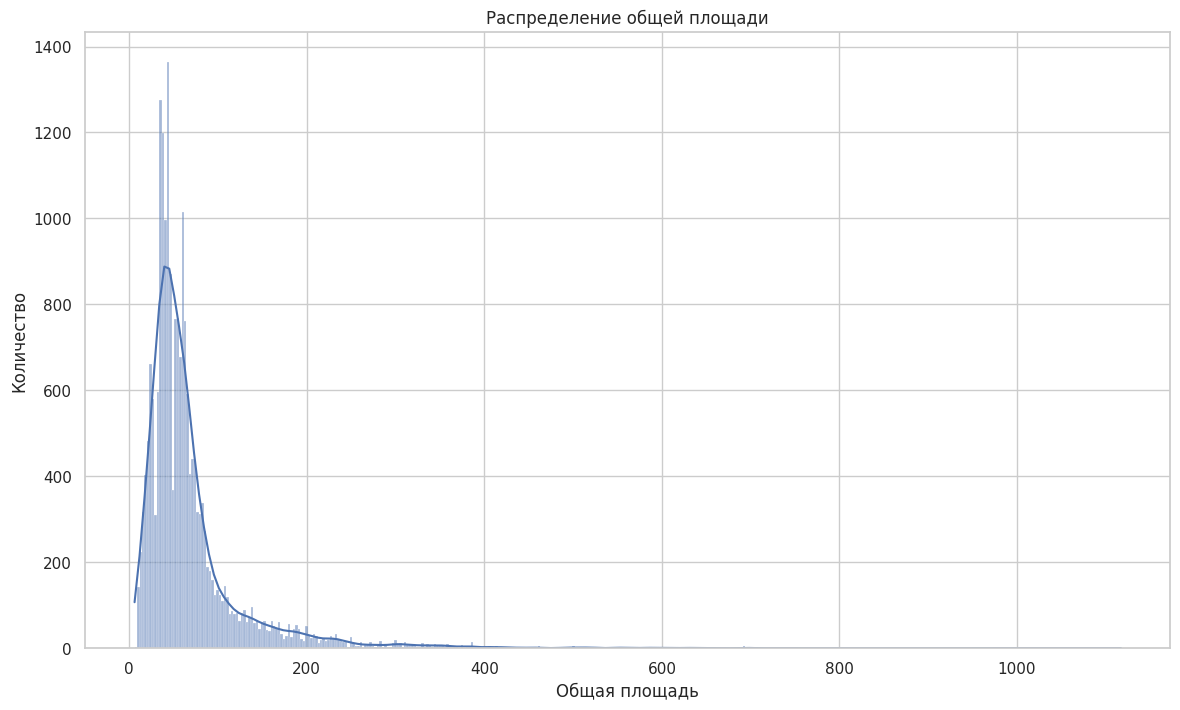

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.histplot(data=df_moscow_flats, x='Area', kde=True)
plt.xlabel("Общая площадь")
plt.ylabel("Количество")
plt.title("Распределение общей площади")
plt.show()

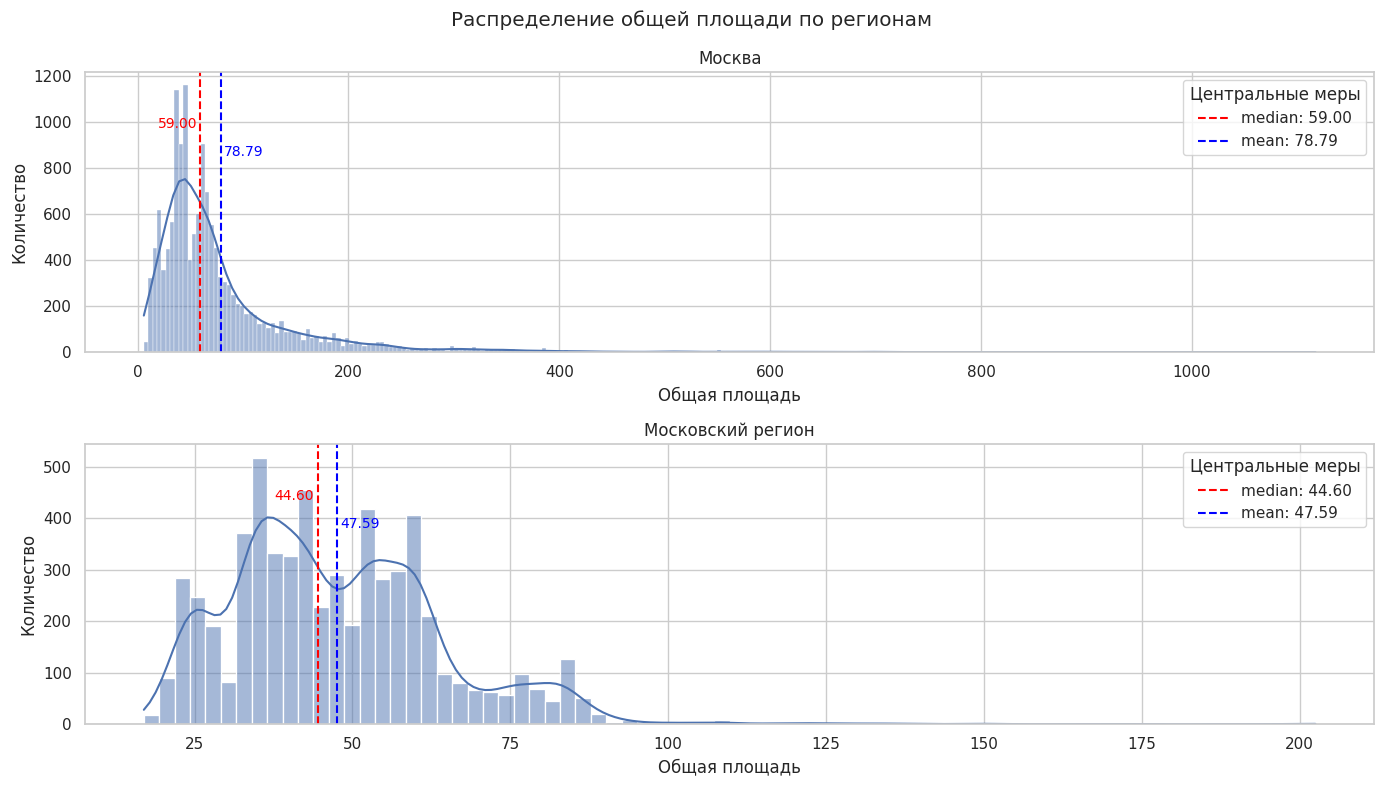

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), dpi=100, tight_layout=True)

sns.histplot(data=df_city_moscow_flats, x='Area', kde=True, ax=axes[0])
axes[0].set_xlabel("Общая площадь")
axes[0].set_ylabel("Количество")
axes[0].set_title("Москва")

median_value_city = df_city_moscow_flats['Area'].median()
mean_value_city = df_city_moscow_flats['Area'].mean()

axes[0].axvline(x=median_value_city, color='red', ls='--', label=f'median: {median_value_city:.2f}')
axes[0].axvline(x=mean_value_city, color='blue', ls='--', label=f'mean: {mean_value_city:.2f}')

axes[0].text(median_value_city - 40, axes[0].get_ylim()[1]*0.8, f'{median_value_city:.2f}', color='red', fontsize=10)
axes[0].text(mean_value_city + 3, axes[0].get_ylim()[1]*0.7, f'{mean_value_city:.2f}', color='blue', fontsize=10)

axes[0].legend(title="Центральные меры")

sns.histplot(data=df_reg_moscow_flats, x='Area', kde=True, ax=axes[1])
axes[1].set_xlabel("Общая площадь")
axes[1].set_ylabel("Количество")
axes[1].set_title("Московский регион")

median_value_reg = df_reg_moscow_flats['Area'].median()
mean_value_reg = df_reg_moscow_flats['Area'].mean()

axes[1].axvline(x=median_value_reg, color='red', ls='--', label=f'median: {median_value_reg:.2f}')
axes[1].axvline(x=mean_value_reg, color='blue', ls='--', label=f'mean: {mean_value_reg:.2f}')

axes[1].text(median_value_reg - 7, axes[1].get_ylim()[1]*0.8, f'{median_value_reg:.2f}', color='red', fontsize=10)
axes[1].text(mean_value_reg + 0.5, axes[1].get_ylim()[1]*0.7, f'{mean_value_reg:.2f}', color='blue', fontsize=10)

axes[1].legend(title="Центральные меры")

plt.suptitle("Распределение общей площади по регионам")
plt.show()

---
**Вывод:**

* В Москве большее количество квартир с высокой площадью, что сказывается на среднем значении. Однако медиана в обеих областях ниже среднего, что говорит о смещённости данных в сторону меньших площадей.
* В Московском регионе распределение более симметричное, с меньшей вариативностью в площадях, а в Москве есть значительное количество квартир с большой площадью.

---

#### Популярные станции метро и их влияние на цену

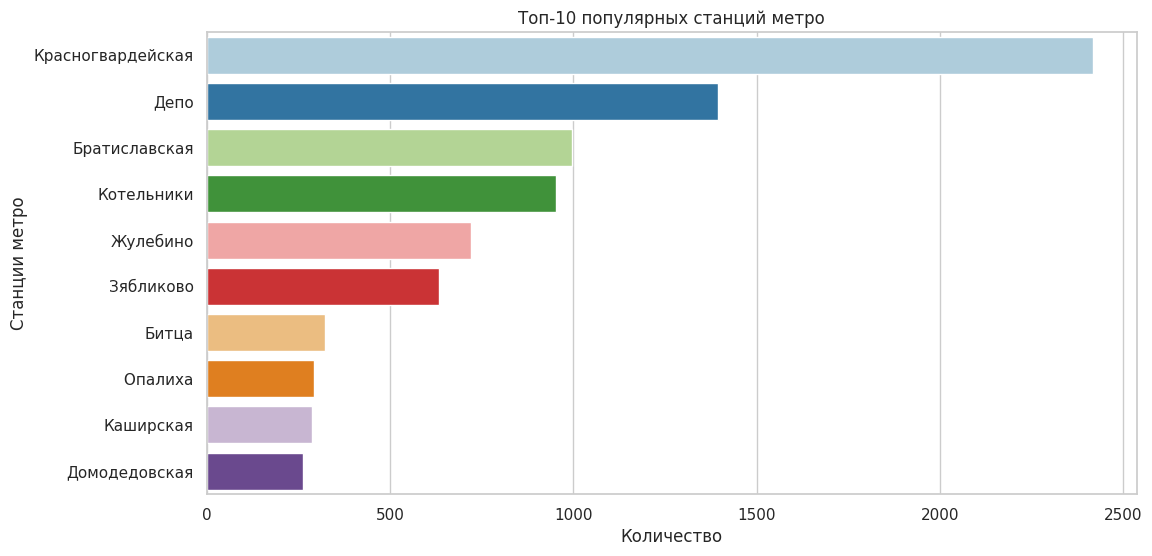

In [ ]:
df_count_metro_st = df_moscow_flats['Metro station'].value_counts()
df_top10_metro = df_count_metro_st.nlargest(n=10).reset_index()

sns.barplot(data=df_top10_metro, y='Metro station', x='count', hue='Metro station', palette='Paired')
plt.ylabel("Станции метро")
plt.xlabel("Количество")
plt.title("Топ-10 популярных станций метро")
plt.show()

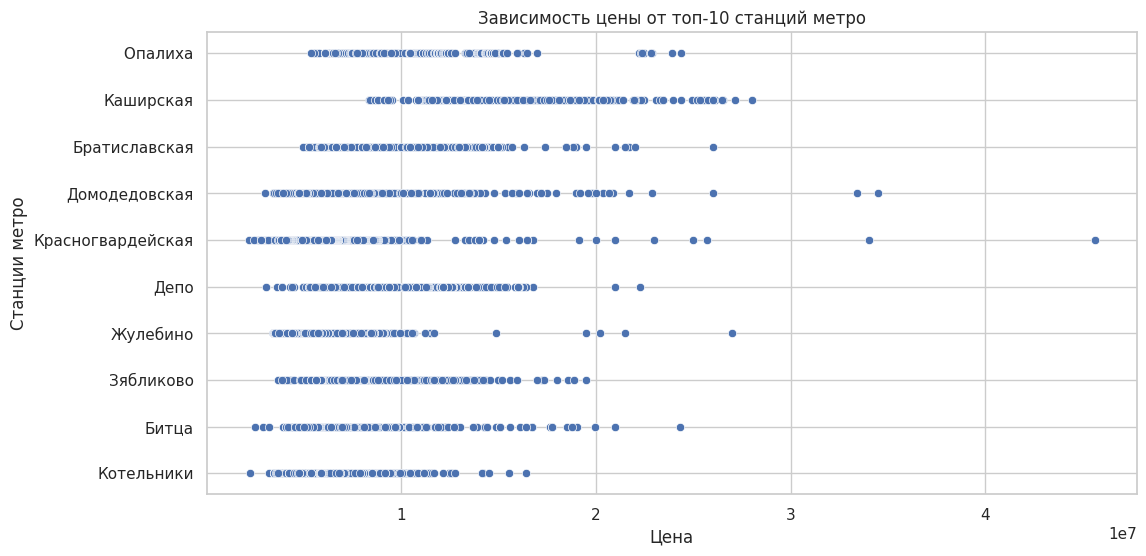

In [ ]:
sns.scatterplot(data=df_moscow_flats[df_moscow_flats['Metro station'].isin(df_top10_metro['Metro station'])], y='Metro station', x='Price')
plt.xlabel("Цена")
plt.ylabel("Станции метро")
plt.title("Зависимость цены от топ-10 станций метро")
plt.show()

---
**Вывод:**

1. Наибольшую популярность имеет станция "Красногвардейская", что значительно превышает количество обращений по сравнению с другими станциями и может быть связано с высоким уровнем транспортной доступности или плотностью населения. Далее следует "Депо", а затем "Братиславская".

2. На втором графике изображена зависимость цен от этих станций метро. Цены в основном распределены до уровня около 20-25 миллионов рублей. Станции, такие как "Опалиха" и "Красногвардейская", имеют более широкий разброс цен, что может указывать на наличие как дорогих, так и более доступных объектов недвижимости рядом с ними. В то же время станции вроде "Каширская" и "Жулебино" имеют меньше разброса в ценах, что может свидетельствовать о более стабильном рынке недвижимости рядом с ними.

3. Цены на недвижимость вокруг станций варьируются. Станции с большим разбросом цен могут быть популярными как для более дорогих, так и для доступных объектов.

4. Отдельные станции метро имеют более предсказуемые ценовые диапазоны, что может указывать на однородность застройки или предложений на рынке.

---

#### Исследование на зависимость между признаками

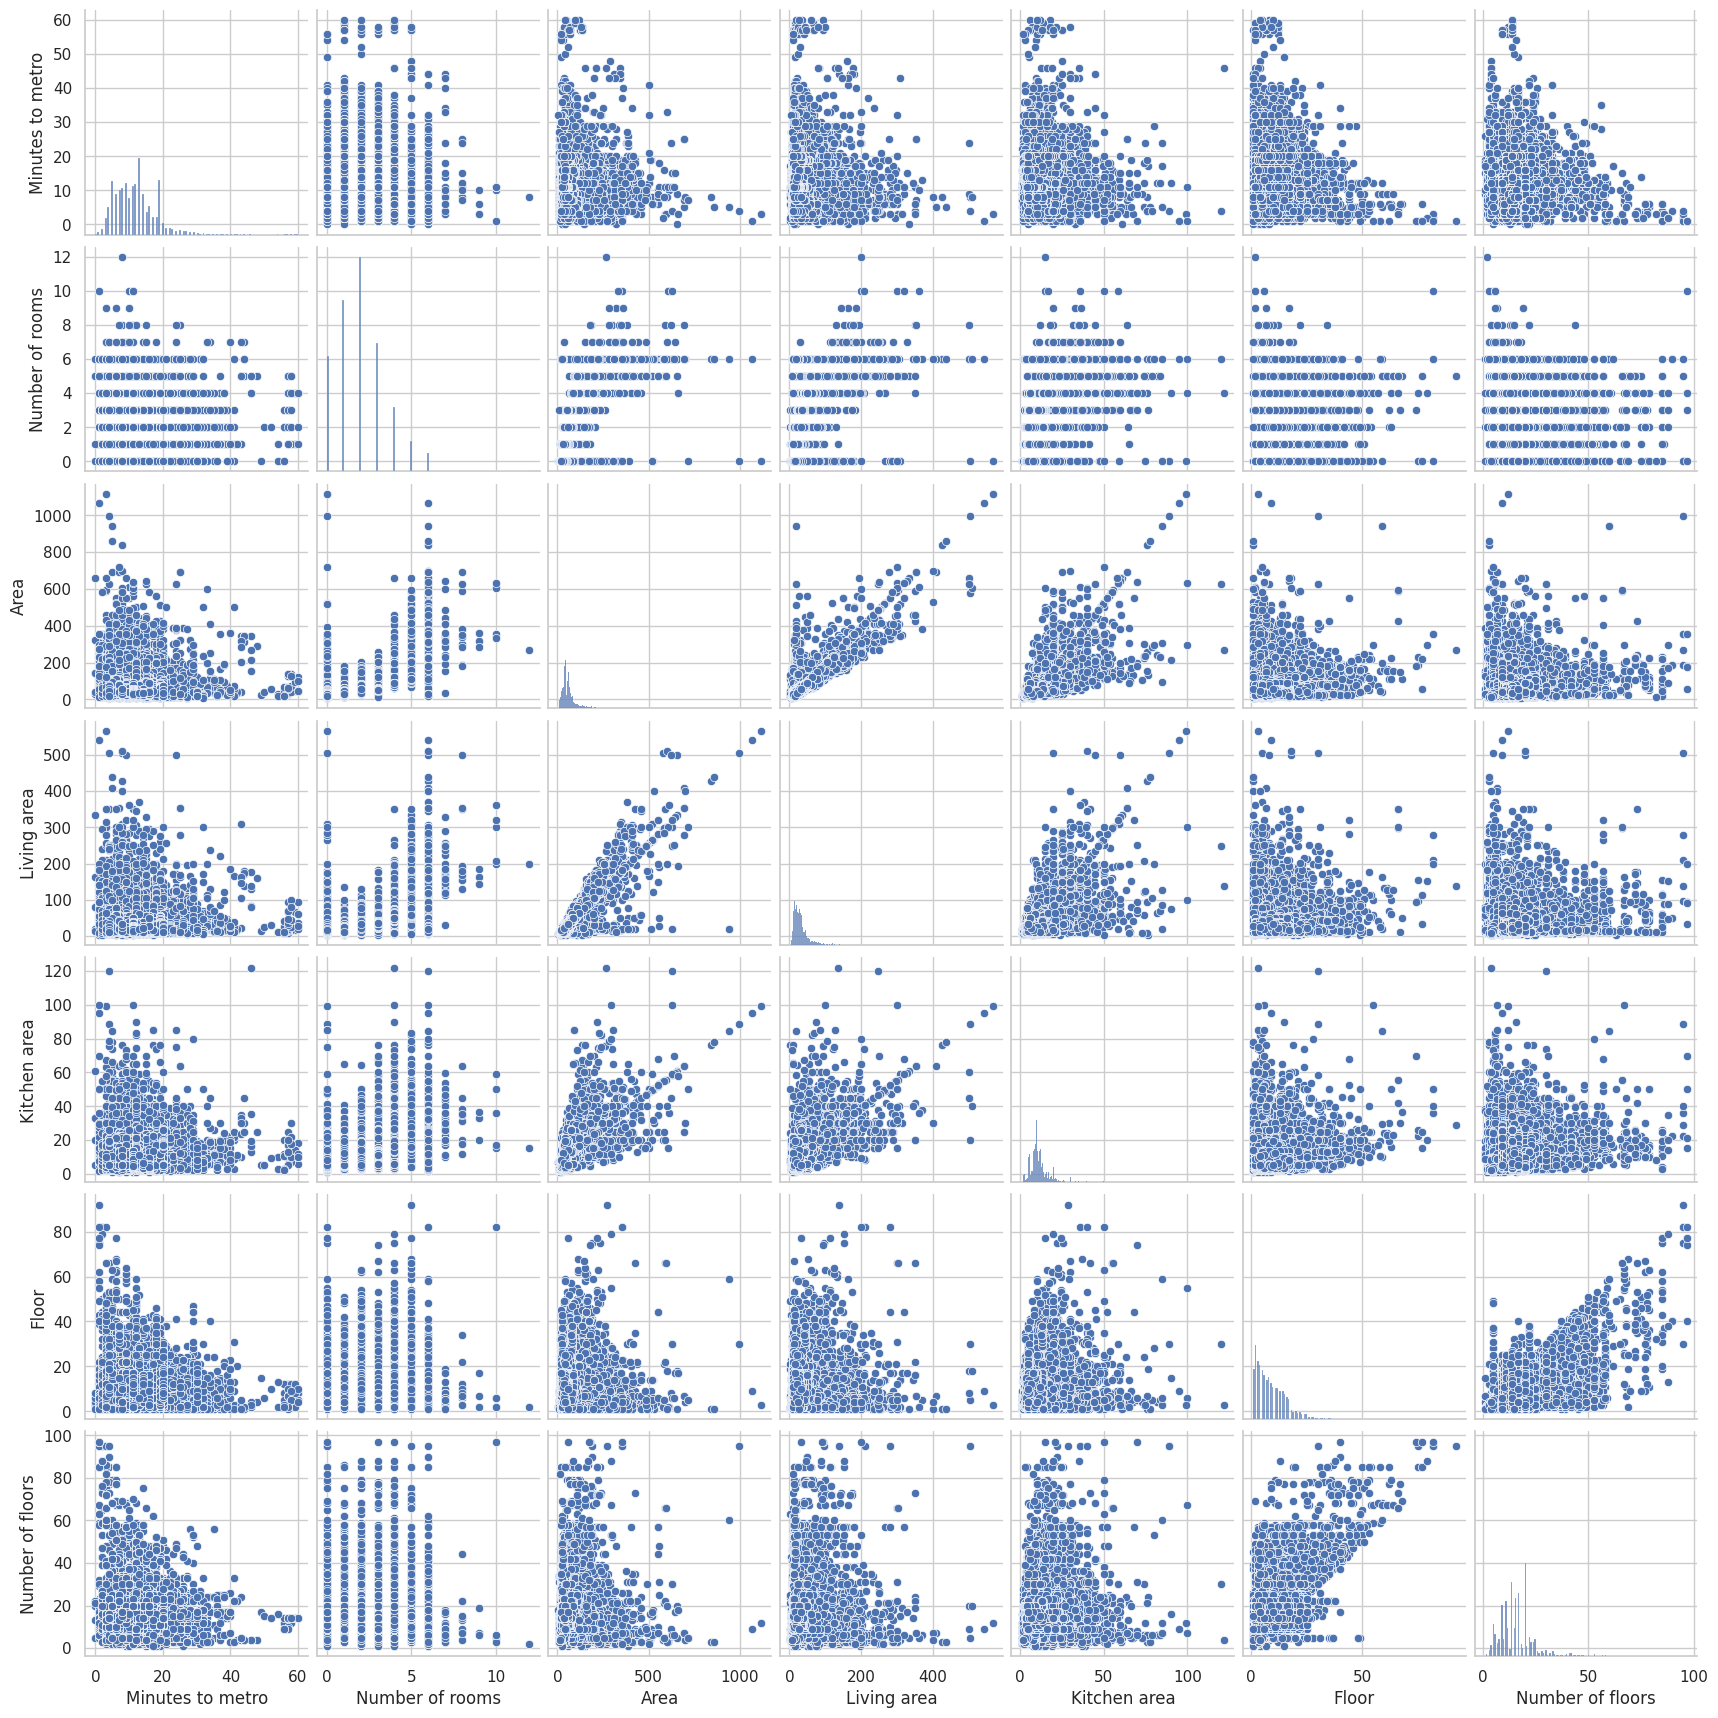

In [ ]:
sns.pairplot(data=df_moscow_flats.drop('Price', axis=1))

---
**Информация по графику:**
1. **Взаимосвязь между площадями:**
    * Сильная положительная корреляция между общей площадью, жилой площадью и площадью кухни. Это логично, так как чем больше общая площадь квартиры, тем больше и другие её части.
    * Также видна чёткая зависимость между жилой площадью и общей площадью (график почти линейный), что говорит о том, что увеличение общей площади связано с пропорциональным увеличением жилой площади.

2. **Количество комнат:**
    * Видна положительная зависимость между количеством комнат и площадями (общей, жилой и кухни). Чем больше комнат, тем, как правило, больше площади.
    * Заметно, что данные группируются по определённым значениям комнат (1, 2, 3 и т.д.), что логично, поскольку количество комнат — дискретная переменная.

3. **Минуты до метро:**
    * Чем больше расстояние до метро, тем меньше площадь квартир. Это может свидетельствовать о том, что квартиры ближе к метро чаще имеют большую площадь.
    * Связь с другими переменными менее очевидна, хотя можно заметить некоторое разрежение данных по мере увеличения времени до метро.

4. **Этаж:**
    * Количество этажей в доме положительно коррелирует с этажом, на котором расположена квартира, что ожидаемо (в более высоких зданиях квартиры расположены на более высоких этажах).
    * Есть слабая отрицательная корреляция между этажом и общей площадью квартиры, что может говорить о том, что на более высоких этажах встречаются квартиры с меньшей площадью.

5. **Количество этажей в здании:**
    * Видна слабая положительная зависимость между количеством этажей в здании и площадью квартир. В более высоких зданиях квартиры могут быть немного больше.

---

---
**Выводы:**

* Основные корреляции наблюдаются между различными типами площадей (общей, жилой, кухонной) и количеством комнат. Эти параметры тесно связаны между собой.
* Время до метро имеет тенденцию к обратной связи с площадью квартир — чем дальше от метро, тем меньше площадь.
* Параметры этажности (этаж квартиры и количество этажей в здании) слабо коррелируют с площадью квартир, но показывают интересные закономерности в зависимости от здания.

---

#### Тепловые карты корреляции

In [ ]:
corr_matrix = df_moscow_flats.select_dtypes(exclude='object').corr()

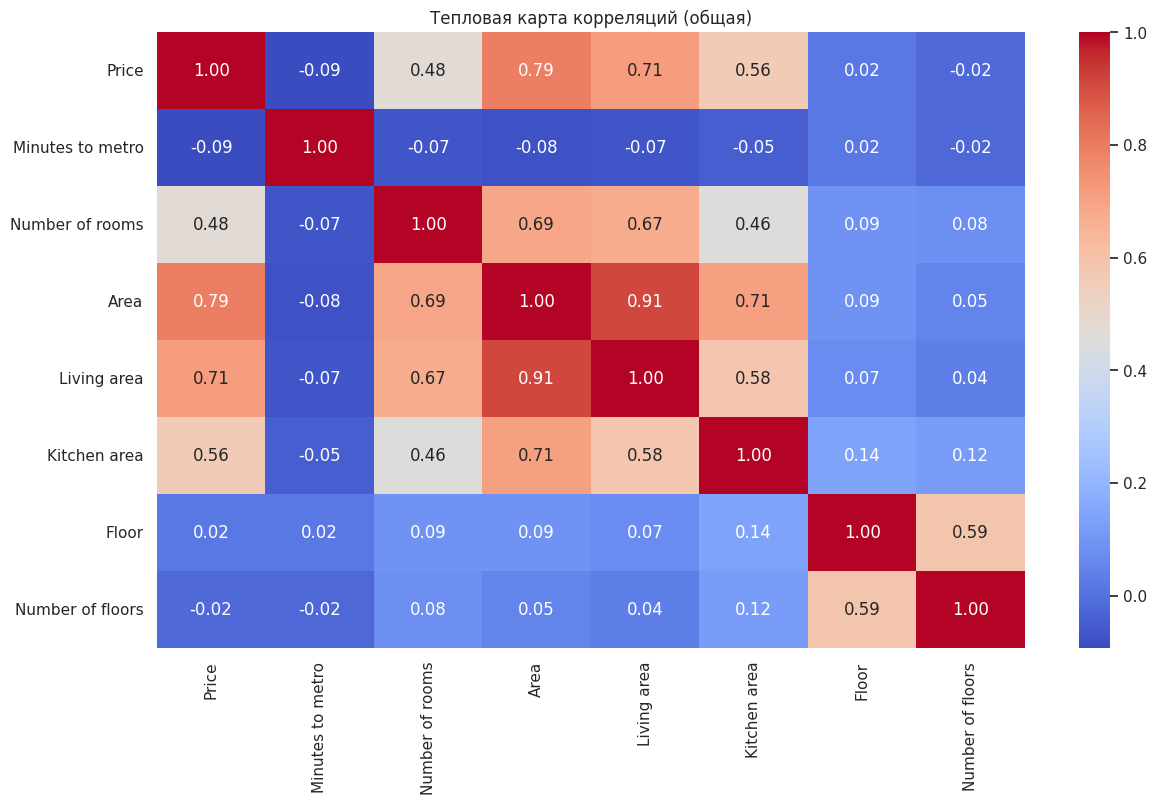

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.heatmap(data=corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Тепловая карта корреляций (общая)")
plt.show()

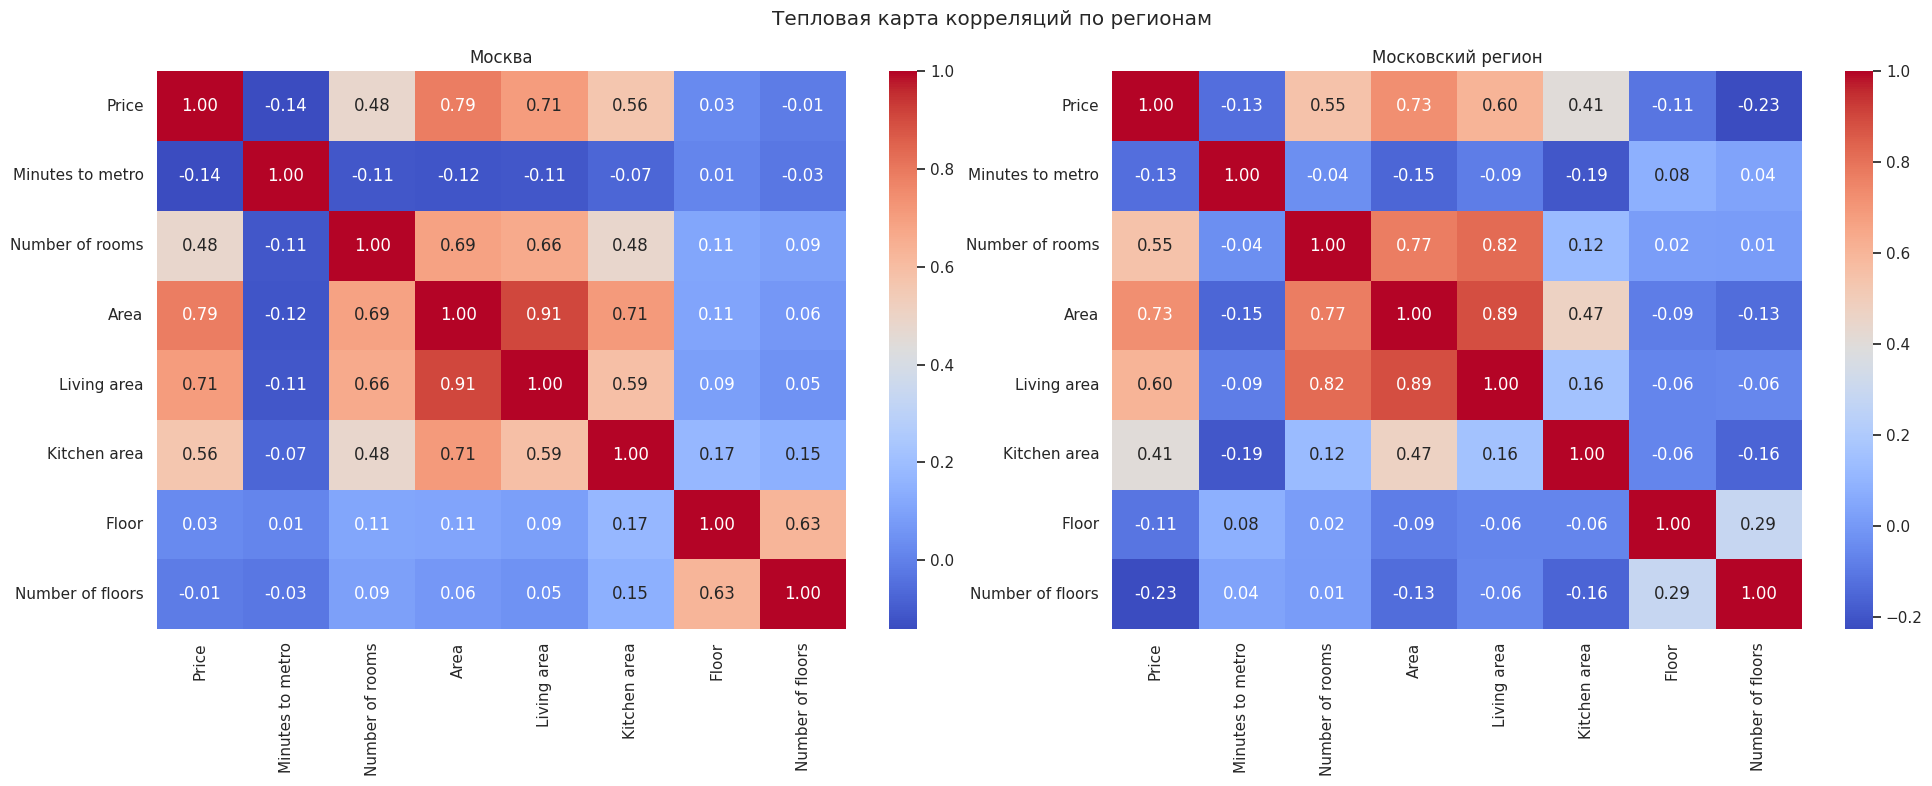

In [ ]:
df_city_moscow_flats_corr = df_city_moscow_flats.select_dtypes(exclude='object').corr()
df_reg_moscow_flats_corr = df_reg_moscow_flats.select_dtypes(exclude='object').corr()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), dpi=100, tight_layout=True)

sns.heatmap(data=df_city_moscow_flats_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0])
axes[0].set_title("Москва")

sns.heatmap(data=df_reg_moscow_flats_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1])
axes[1].set_title("Московский регион")

plt.suptitle("Тепловая карта корреляций по регионам")
plt.show()

---
**Выводы:**

1. **Сильное влияние площади и комнат на цену:**
    * Площадь и жилая площадь оказывают значительное влияние на цену в обоих регионах. Количество комнат также связано с ценой, но в меньшей степени.

2. **Слабое влияние этажности и близости к метро:**
    * Этаж, количество этажей в здании и расстояние до метро оказывают минимальное влияние на цену, что предполагает их незначительную роль в определении стоимости жилья.

3. **Мультиколлинеарность:**
    * *Москва:*
        * Сильная корреляция между общей площадью и жилой площадью (0.91), общей площадью и площадью кухни (0.71) указывает на мультиколлинеарность, которая может отрицательно сказаться на регрессионных моделях.

    * *Московский регион:*
        * Сильная корреляция между общей площадью и количеством комнат (0.77), жилой площадью и количеством комнат (0.82), общей площадью и жилой площадью (0.89) указывает на мультиколлинеарность, которая может отрицательно сказаться на регрессионных моделях.

---

## Пребразование данных

### Преобразуем целевую переменную

---
Гипотеза о наличии гетероскедастичности, в целом, очевидна, однако ее следует проверить (проведем только визуальную проверку).

---

##### Исходные данные

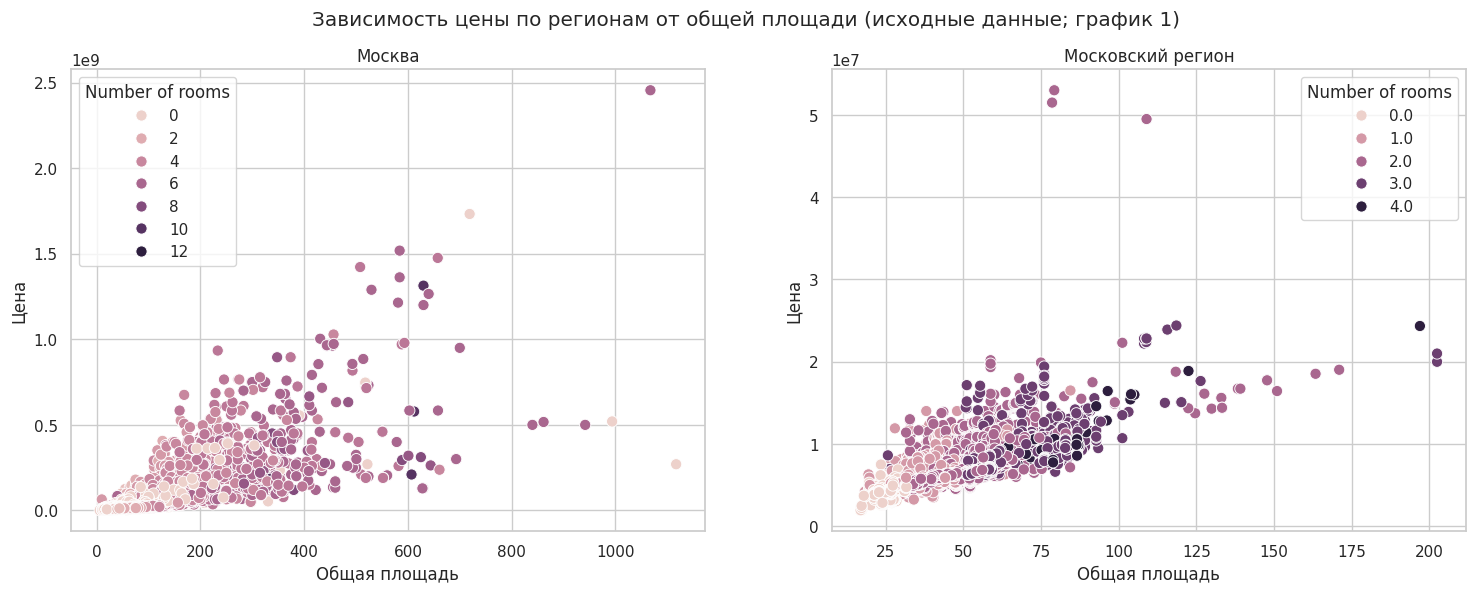

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(data=df_city_moscow_flats, x='Area', y='Price', s=65, hue='Number of rooms', ax=axes[0])
axes[0].set_xlabel("Общая площадь")
axes[0].set_ylabel("Цена")
axes[0].set_title("Москва")

sns.scatterplot(data=df_reg_moscow_flats, x='Area', y='Price', s=65, hue='Number of rooms', ax=axes[1])
axes[1].set_xlabel("Общая площадь")
axes[1].set_ylabel("Цена")
axes[1].set_title("Московский регион")

plt.suptitle("Зависимость цены по регионам от общей площади (исходные данные; график 1)")
plt.show()

##### Избавимся от выбросов

In [ ]:
Q1 = np.quantile(df_city_moscow_flats['Price'], 0.25)
Q3 = np.quantile(df_city_moscow_flats['Price'], 0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q1 + 1.5 * IQR

df_city_moscow_flats = df_city_moscow_flats[(df_city_moscow_flats['Price'] >= lower_bound) & (df_city_moscow_flats['Price'] <= upper_bound)]

In [ ]:
Q1 = np.quantile(df_reg_moscow_flats['Price'], 0.25)
Q3 = np.quantile(df_reg_moscow_flats['Price'], 0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q1 + 1.5 * IQR

df_reg_moscow_flats = df_reg_moscow_flats[(df_reg_moscow_flats['Price'] >= lower_bound) & (df_reg_moscow_flats['Price'] <= upper_bound)]

##### Посмотрим данные без выбросов

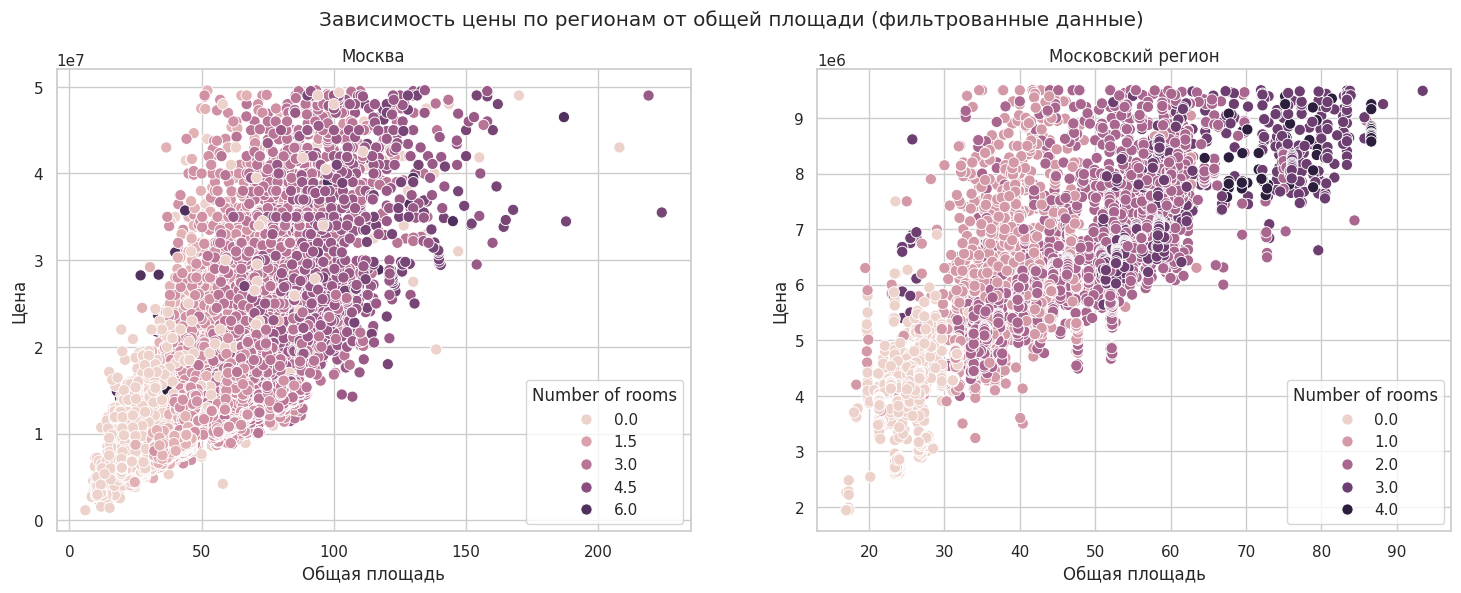

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(data=df_city_moscow_flats, x='Area', y='Price', s=65, hue='Number of rooms', ax=axes[0])
axes[0].set_xlabel("Общая площадь")
axes[0].set_ylabel("Цена")
axes[0].set_title("Москва")

sns.scatterplot(data=df_reg_moscow_flats, x='Area', y='Price', s=65, hue='Number of rooms', ax=axes[1])
axes[1].set_xlabel("Общая площадь")
axes[1].set_ylabel("Цена")
axes[1].set_title("Московский регион")

plt.suptitle("Зависимость цены по регионам от общей площади (фильтрованные данные)")
plt.show()

##### Логарифмируем целевую переменную

In [ ]:
df_city_moscow_flats['Price'] = np.log1p(df_city_moscow_flats['Price'])
df_reg_moscow_flats['Price'] = np.log1p(df_reg_moscow_flats['Price'])

##### Посмотрим на фильтрованную логарифмированную целевую переменную

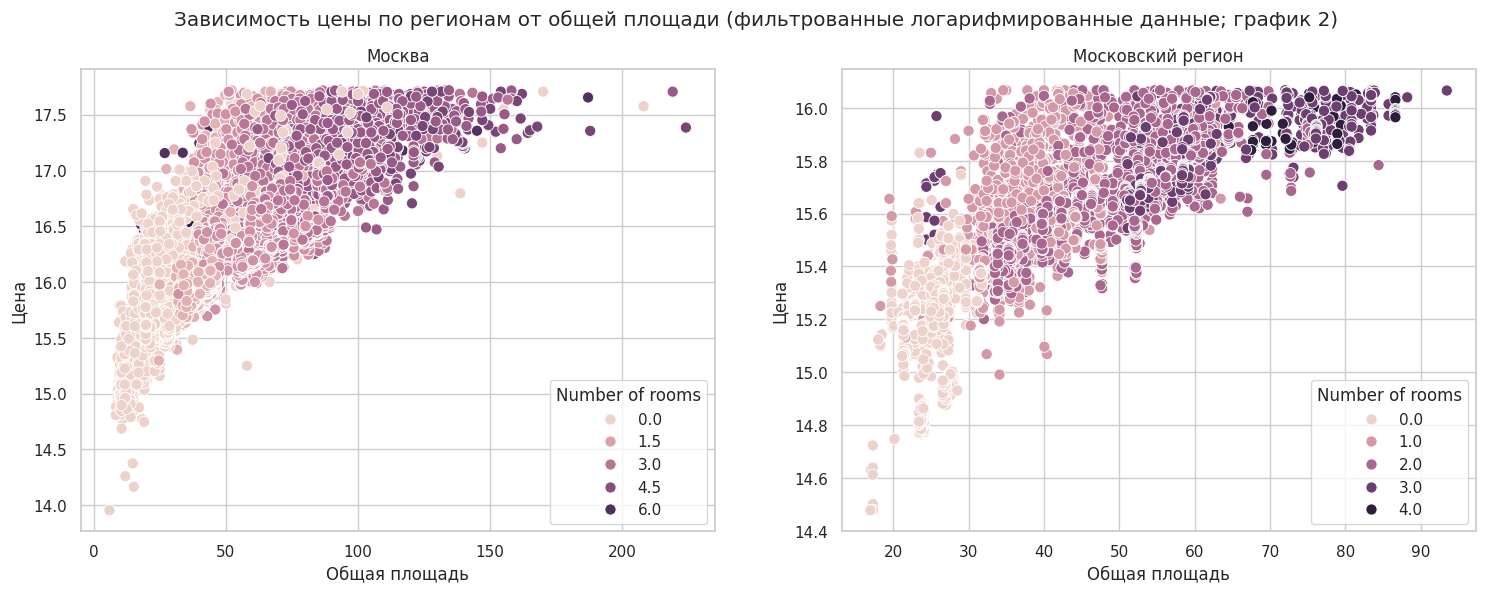

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(data=df_city_moscow_flats, x='Area', y='Price', s=65, hue='Number of rooms', ax=axes[0])
axes[0].set_xlabel("Общая площадь")
axes[0].set_ylabel("Цена")
axes[0].set_title("Москва")

sns.scatterplot(data=df_reg_moscow_flats, x='Area', y='Price', s=65, hue='Number of rooms', ax=axes[1])
axes[1].set_xlabel("Общая площадь")
axes[1].set_ylabel("Цена")
axes[1].set_title("Московский регион")

plt.suptitle("Зависимость цены по регионам от общей площади (фильтрованные логарифмированные данные; график 2)")
plt.show()

---
**Вывод:**

Наличие гетероскедасичности подтвердилось графиком 1. Избавиться от гетероскедастичность не удалось, однако удалось ее уменьшить (смотреть график 2) за счет логарифмирования целевой переменной, т.е. цены.

---

### Кодируем категориальные переменные и избавляемся от некоторых из них

---
Удалим признаки "Станции метро" и "Регион", т.к. первый признак содержит слишком много значений (возможно, его удаление некорректно, однако моделям будет сложно работать с ним), а второй содержит представляет лишь одно значение для разделенных датафреймов по нему же.

---

In [ ]:
df_reg_moscow_flats1 = df_reg_moscow_flats.copy()

df_reg_moscow_flats1 = df_reg_moscow_flats1.drop(['Metro station', 'Region'], axis=1)

df_city_moscow_flats1 = df_city_moscow_flats.copy()

df_city_moscow_flats1 = df_city_moscow_flats1.drop(['Metro station', 'Region'], axis=1)

---
Воспользуемся LabelEncoder для кодировки признака "Тип апартаментов", т.к. он содержит всего два значения, а это равносильно One-Hot Encoding.

Воспольуемся One-Hot-Encoding с удалением первого подпризнака для устранения возможного его влияния на другие подпризнаки данного признака.

---

In [ ]:
label_encoder = LabelEncoder()

df_reg_moscow_flats1['Apartment type'] = label_encoder.fit_transform(df_reg_moscow_flats1['Apartment type'])

df_reg_moscow_flats1 = pd.get_dummies(df_reg_moscow_flats1, columns=['Renovation'], drop_first=True)

In [ ]:
label_encoder = LabelEncoder()

df_city_moscow_flats1['Apartment type'] = label_encoder.fit_transform(df_city_moscow_flats1['Apartment type'])

df_city_moscow_flats1 = pd.get_dummies(df_city_moscow_flats1, columns=['Renovation'], drop_first=True)

---
Разделим данные на тренировочную и тестовую выборки (в дальнейшем тренировочная выборка будет состоять из тренировочной и валидационной выборок, т.е. мы реализовать обучение моделей с помощью кроссвалидации с KFold Validation + Hold-Out Validation).

---

In [ ]:
X = df_reg_moscow_flats1.drop('Price', axis=1)
y = df_reg_moscow_flats1['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_city = df_city_moscow_flats1.drop('Price', axis=1)
y_city = df_city_moscow_flats1['Price']

X_train_city, X_test_city, y_train_city, y_test_city = train_test_split(X_city, y_city, test_size=0.2, random_state=42)

## Работаем с множеством моделей (AutoML) через TPOT

### Обучаем TPOT

#### Московский регион

In [ ]:
tpot_regressor = TPOTRegressor(
    generations=5,
    population_size=50,
    verbosity=2,
    n_jobs=-1,
    scoring='r2',
    random_state=42
)

tpot_regressor.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9087674185244461

Generation 2 - Current best internal CV score: 0.9087674185244461

Generation 3 - Current best internal CV score: 0.9130845104219947

Generation 4 - Current best internal CV score: 0.9130845104219947

Generation 5 - Current best internal CV score: 0.9130845104219947

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.9000000000000001, min_samples_leaf=1, min_samples_split=12, n_estimators=100)


TPOTRegressor(generations=5, n_jobs=-1, population_size=50, random_state=42,
              scoring='r2', verbosity=2)

---
**Вывод:**

Наилучшей регрессионной моделью для данных с регионом "Московский регион" оказалась ExtraTreesRegressor.

---

#### Москва

In [ ]:
tpot_regressor_city = TPOTRegressor(
    generations=5,
    population_size=50,
    verbosity=2,
    n_jobs=-1,
    scoring='r2',
    random_state=42
)

tpot_regressor_city.fit(X_train_city, y_train_city)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8963649252452524

Generation 2 - Current best internal CV score: 0.8963649252452524

Generation 3 - Current best internal CV score: 0.8963649252452524

Generation 4 - Current best internal CV score: 0.8963649252452524

Generation 5 - Current best internal CV score: 0.8963649252452524

Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.85, learning_rate=0.1, loss=huber, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=5, min_samples_split=7, n_estimators=100, subsample=0.9500000000000001)


TPOTRegressor(generations=5, n_jobs=-1, population_size=50, random_state=42,
              scoring='r2', verbosity=2)

---
**Вывод:**

Наилучшей регрессионной моделью для данных с регионом "Москва" оказался градиентный бустинг.

---

#### **Заключение**

---
**Заключение:**

Для "Москва" лучше подойдет градиентный бустинг, а для "Московский регион" - ExtraTreesRegressor.

---

### Проверим модели на логарифмированных данных

#### Московский регион

---
Вычислим метрики для тренировочной и тестовой выборок.

---

In [ ]:
y_train_pred = tpot_regressor.predict(X_train)
y_test_pred = tpot_regressor.predict(X_test)

mean_absolute_error_train = mean_absolute_error(y_train, y_train_pred)
mean_absolute_error_test = mean_absolute_error(y_test, y_test_pred)

root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
root_mean_squared_error_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

---
Сравним результаты метрик с средней ценой региона.

---

In [ ]:
y.mean()

15.60423340015733

In [ ]:
mean_absolute_error_train

0.0415448557832084

In [ ]:
mean_absolute_error_test

0.059145707645255195

In [ ]:
root_mean_squared_error_train

0.05597769915808996

In [ ]:
root_mean_squared_error_test

0.08155867469700205

---
Ошибки оказались довольно маленькими, что свидетельствует о хороших выборе модели и предсказательной способности. Также можно заметить, что модель хорошо обучена (соблюдает баланс между недообученостью и переобученностью).

---

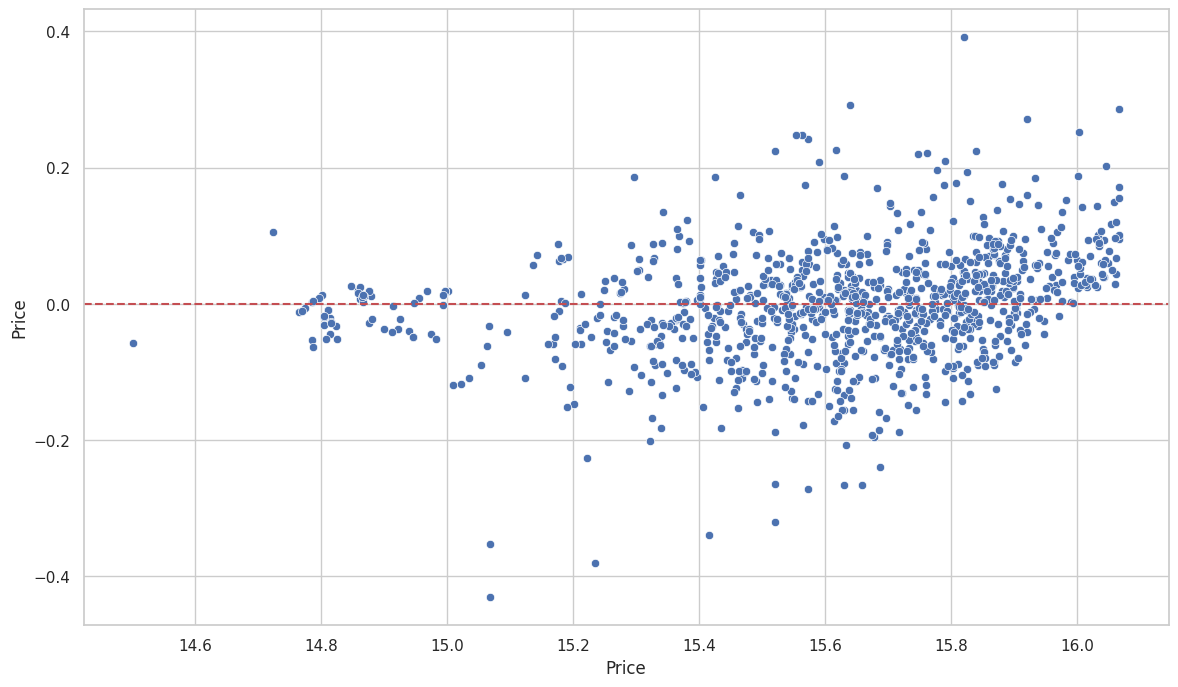

In [ ]:
test_res = y_test - y_test_pred

plt.figure(figsize=(14, 8), dpi=100)
sns.scatterplot(
    x=y_test,
    y=test_res,
)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

---
На графике видно, что присутствует гетероскедастичность (с увеличением цены увеличивается и разброс предсказанных цен). Ошибки распределены довольно случайно относительно линии нуля, что говорит лишь о наличии проблемы гетероскедастичности. Также на графике остатков можно наблюдать выбросы.

---

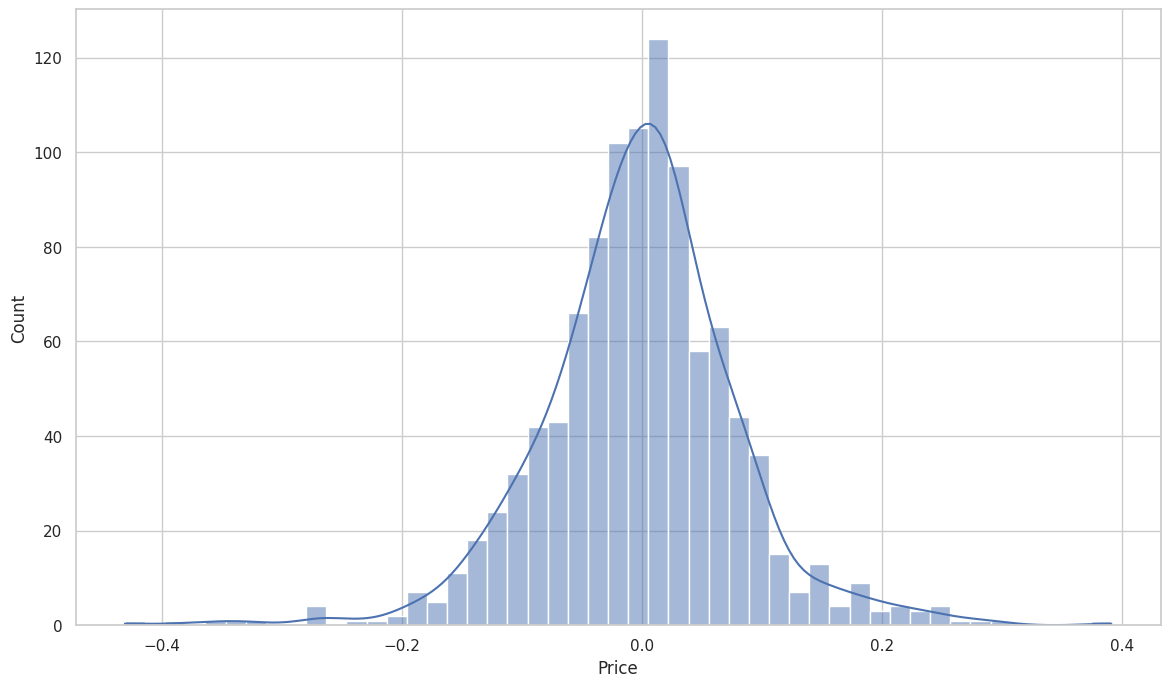

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.histplot(data=test_res, kde=True)
plt.show()

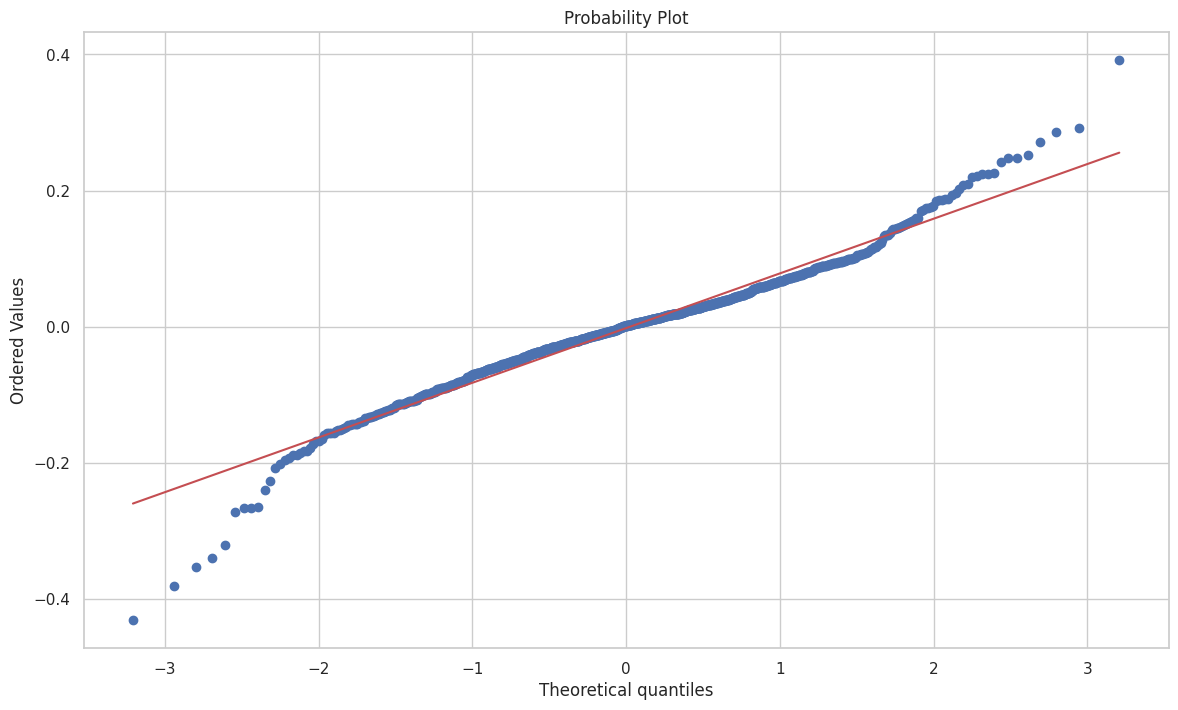

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
_ = sp.stats.probplot(test_res, plot=ax)

---
По графику распределения и Q-Q можно заметить, что распределение почти нормальное, но имеются выбросы, которые препятствуют достижению нормальности.

---

#### Москва

---
Вычислим метрики для тренировочной и тестовой выборок.

---

In [ ]:
y_train_city_pred = tpot_regressor_city.predict(X_train_city)
y_test_city_pred = tpot_regressor_city.predict(X_test_city)

mean_absolute_error_train = mean_absolute_error(y_train_city, y_train_city_pred)
mean_absolute_error_test = mean_absolute_error(y_test_city, y_test_city_pred)

root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train_city, y_train_city_pred))
root_mean_squared_error_test = np.sqrt(mean_squared_error(y_test_city, y_test_city_pred))

---
Сравним результаты метрик с средней ценой региона.

---

In [ ]:
y_city.mean()

16.417278349237833

In [ ]:
mean_absolute_error_train

0.09054321713336479

In [ ]:
mean_absolute_error_test

0.13540106538779245

In [ ]:
root_mean_squared_error_train

0.1377430391573971

In [ ]:
root_mean_squared_error_test

0.19826338259269044

---
Ошибки оказались приемлимыми, что свидетельствует о неплохом выборе модели и предсказательной способности с учетом широкого диапазона цен. Также можно заметить, что модель хорошо обучена (соблюдает баланс между недообученостью и переобученностью).

---

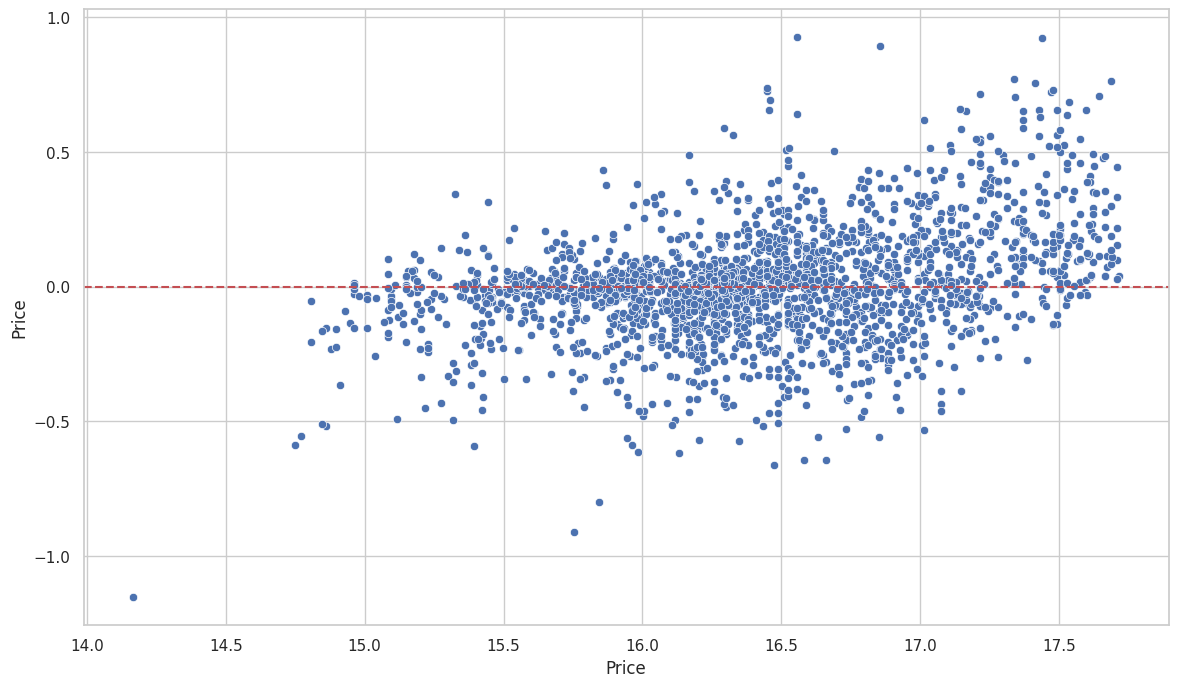

In [ ]:
test_res = y_test_city - y_test_city_pred

plt.figure(figsize=(14, 8), dpi=100)
sns.scatterplot(
    x=y_test_city,
    y=test_res,
)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

---
На графике видно, что присутствует гетероскедастичность (с увеличением цены увеличивается и разброс предсказанных цен). Ошибки распределены довольно случайно относительно линии нуля, что говорит лишь о наличии проблемы гетероскедастичности. Также на графике остатков можно наблюдать выбросы.

---


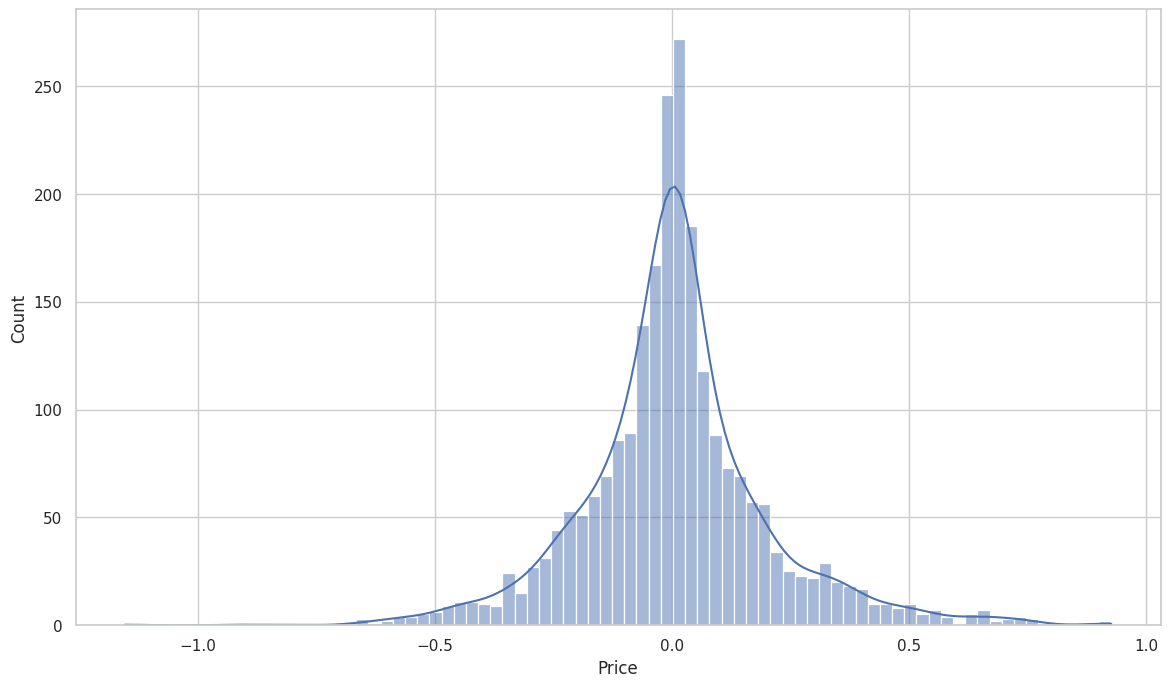

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.histplot(data=test_res, kde=True)
plt.show()

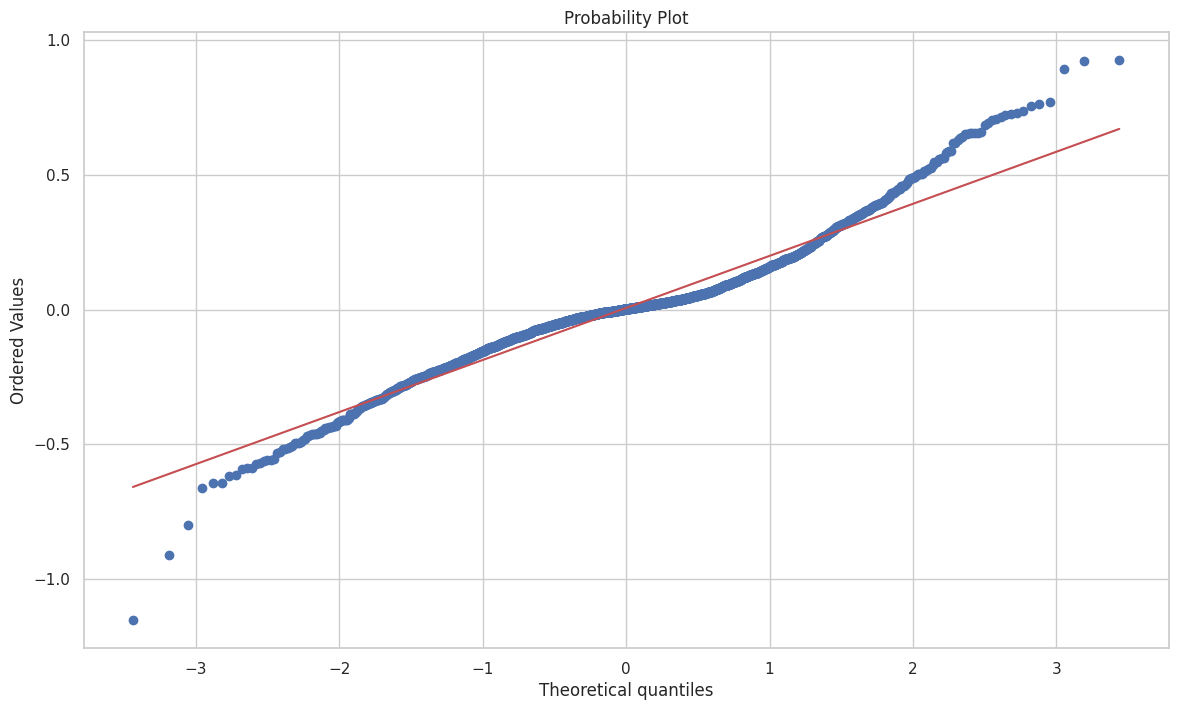

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
_ = sp.stats.probplot(test_res, plot=ax)

---
На основе графиков можно сделать вывод: распределение не идеально нормально, но в центральной части данных оно близко к нормальному; отклонения на концах указывают на наличие выбросов или длинных хвостов.

---

### Проверим модель на оригинальных данных

#### Московский регион

---
Вычислим метрики для тренировочной и тестовой выборок.

---

In [ ]:
y_train_original = np.expm1(y_train)
y_train_pred_original = np.expm1(y_train_pred)

y_test_original = np.expm1(y_test)
y_test_pred_original = np.expm1(y_test_pred)

res_test_original = y_test_original - y_test_pred_original

mean_absolute_error_train = mean_absolute_error(y_train_original, y_train_pred_original)
mean_absolute_error_test = mean_absolute_error(y_test_original, y_test_pred_original)

root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
root_mean_squared_error_test = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))

---
Сравним результаты метрик с средней ценой региона.

---

In [ ]:
np.expm1(y.mean())

5981806.873121447

In [ ]:
mean_absolute_error_train

258884.13813669328

In [ ]:
mean_absolute_error_test

375011.10590385995

In [ ]:
root_mean_squared_error_train

355665.0408896285

In [ ]:
root_mean_squared_error_test

524135.9949360187

---
Ошибки оказались довольно маленькими, что свидетельствует о хороших выборе модели и предсказательной способности. Также можно заметить, что модель хорошо обучена (соблюдает баланс между недообученостью и переобученностью).

---

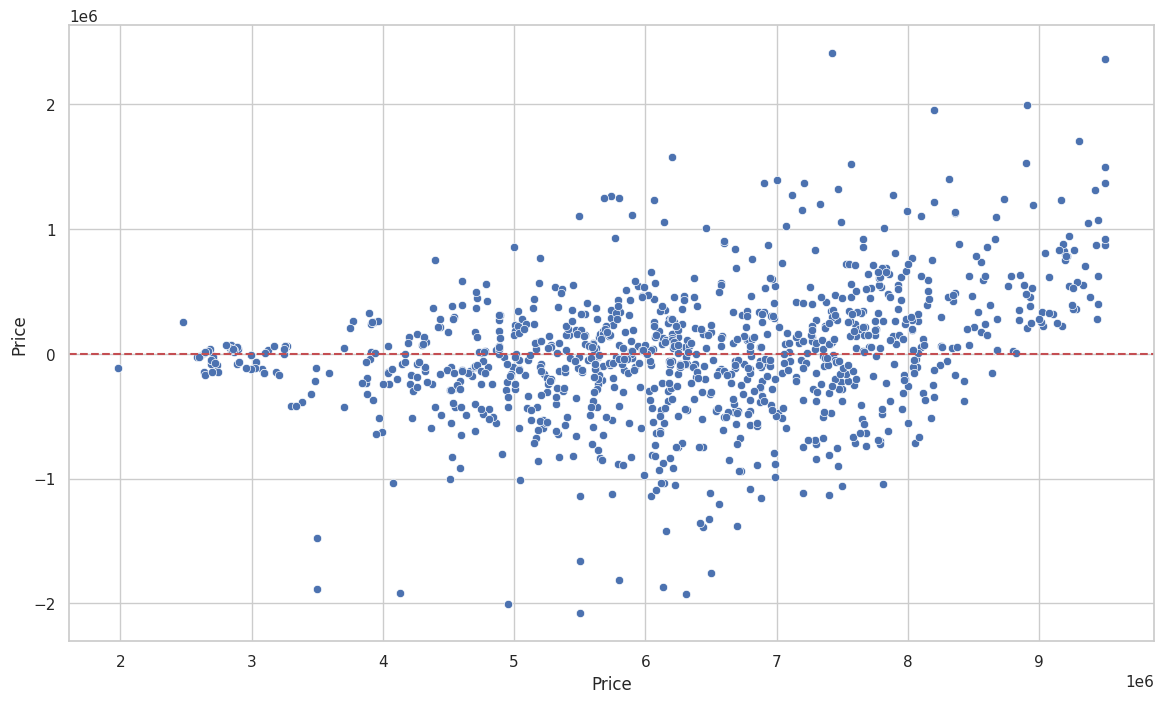

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.scatterplot(
    x=y_test_original,
    y=res_test_original,
)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

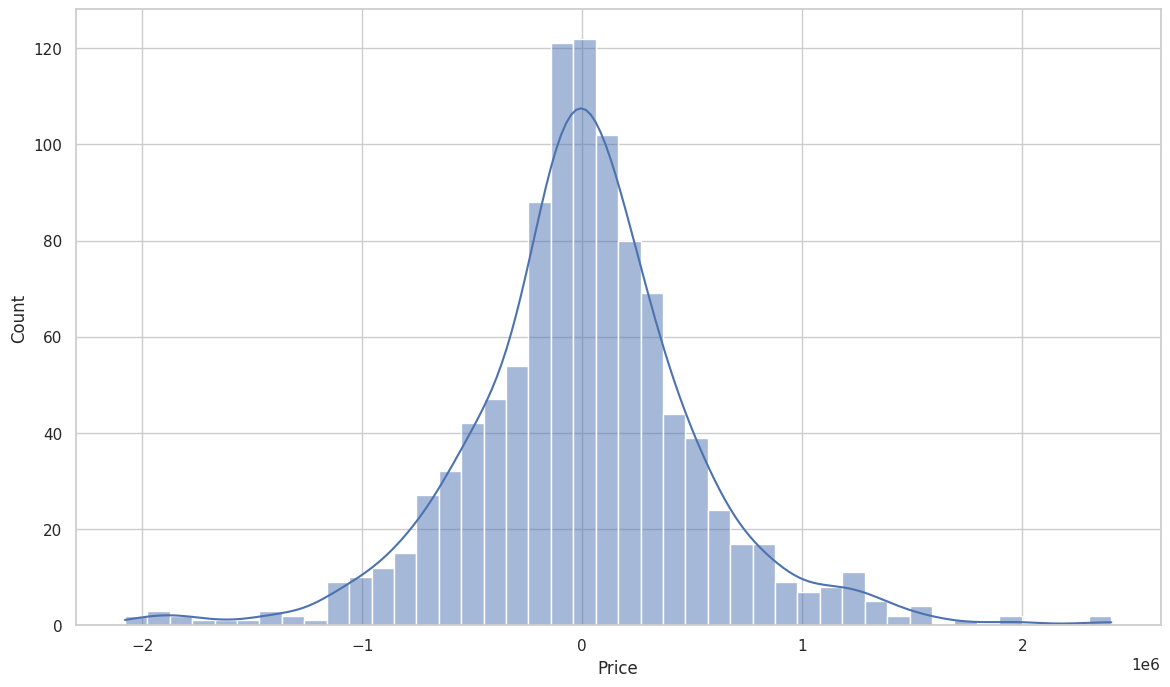

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.histplot(data=res_test_original, kde=True)
plt.show()

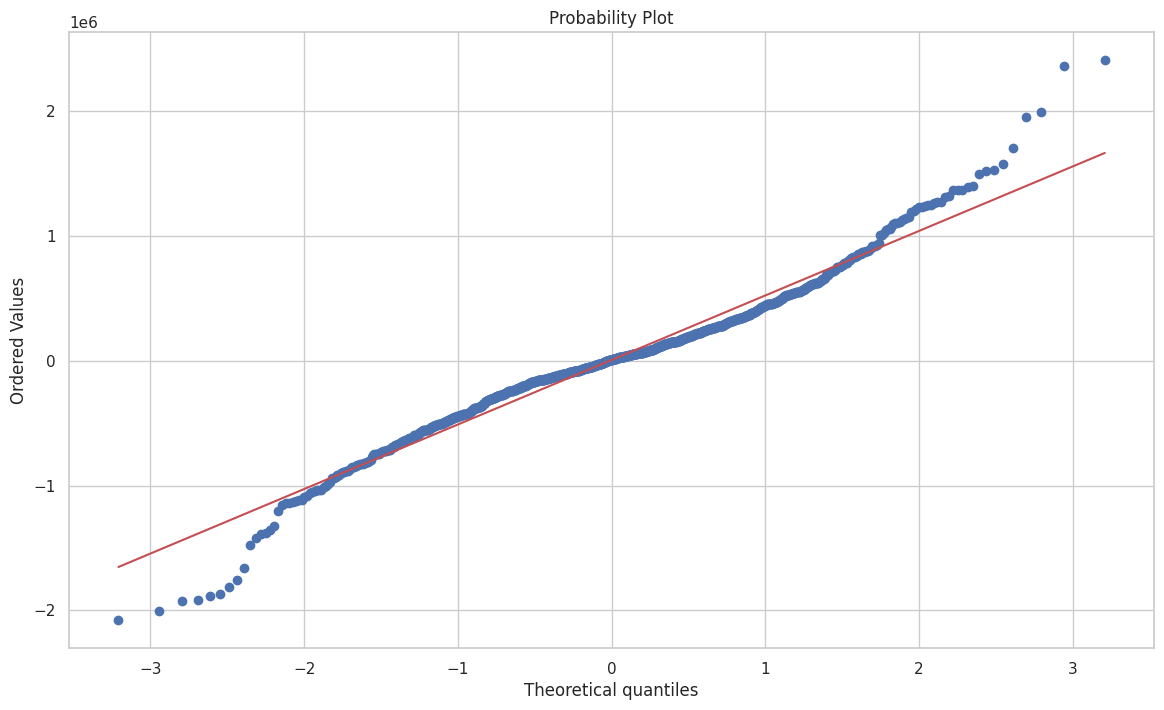

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
_ = sp.stats.probplot(res_test_original, plot=ax)

---
Выводы по графикам остаются такаими же.

---


#### Москва

In [ ]:
y_train_original = np.expm1(y_train_city)
y_train_pred_original = np.expm1(y_train_city_pred)

y_test_original = np.expm1(y_test_city)
y_test_pred_original = np.expm1(y_test_city_pred)

res_test_original = y_test_original - y_test_pred_original

mean_absolute_error_train = mean_absolute_error(y_train_original, y_train_pred_original)
mean_absolute_error_test = mean_absolute_error(y_test_original, y_test_pred_original)

root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
root_mean_squared_error_test = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))

In [ ]:
np.expm1(y_city).mean()

16114125.65102317

In [ ]:
mean_absolute_error_train

1591380.8843573357

In [ ]:
mean_absolute_error_test

2404047.3160957303

In [ ]:
root_mean_squared_error_train

2913209.1785688545

In [ ]:
root_mean_squared_error_test

4118137.2795838523

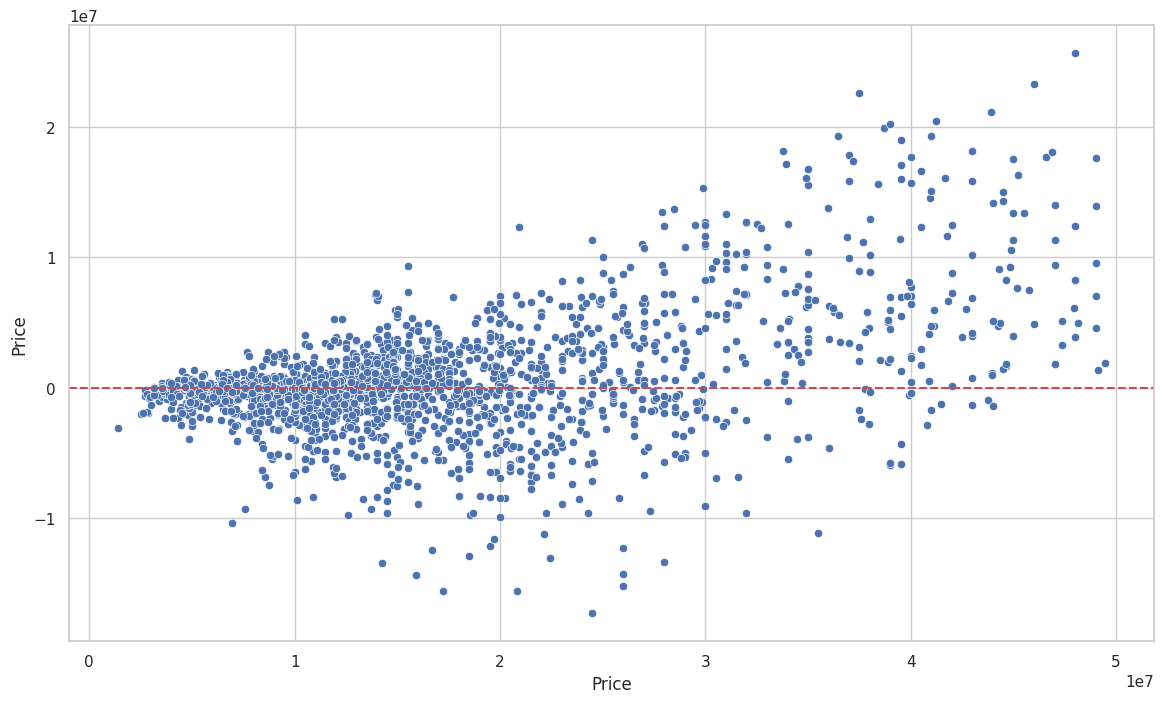

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.scatterplot(
    x=y_test_original,
    y=res_test_original,
)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

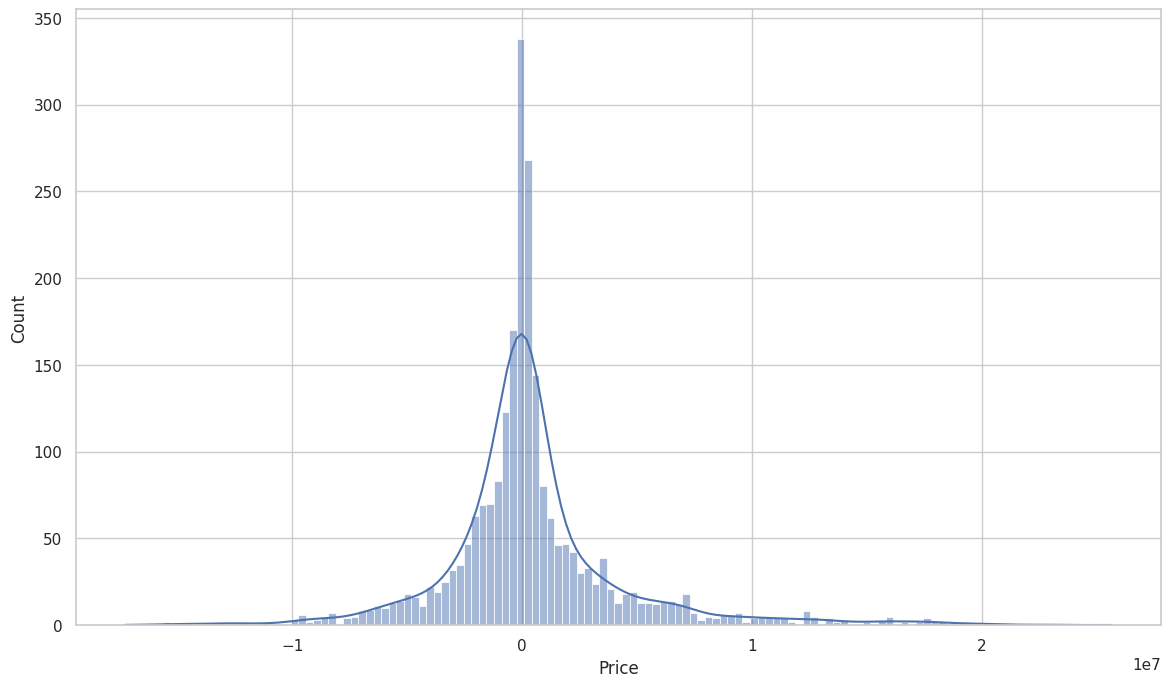

In [ ]:
plt.figure(figsize=(14, 8), dpi=100)
sns.histplot(data=res_test_original, kde=True)
plt.show()

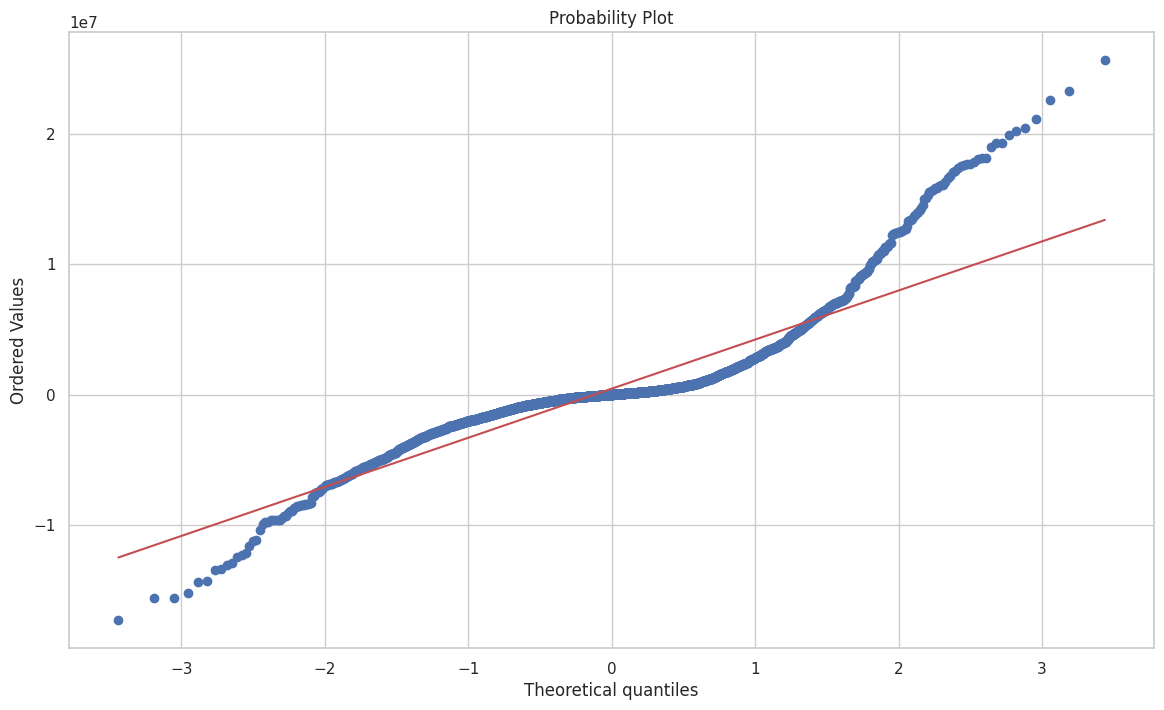

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
_ = sp.stats.probplot(res_test_original, plot=ax)

---
Распределение можно считать приближенным к нормальному. Такой эффект, возможно, достигается за счет очень широкого диапазона цен.

---


### 6. Какие факторы оказывают наибольшее влияние на цены на жилье?

#### Подготовка к визуализации важности признаков

In [ ]:
extra_model: ExtraTreesRegressor = tpot_regressor.fitted_pipeline_.steps[-1][-1]

In [ ]:
importances = extra_model.feature_importances_ * 100
feature_names = X.columns


features = pd.DataFrame({'Признаки': feature_names, 'Важность (%)': importances}).sort_values(by='Важность (%)', ascending=False).reset_index(drop=True)

In [ ]:
grad_boost: GradientBoostingRegressor = tpot_regressor_city.fitted_pipeline_.steps[-1][-1]

In [ ]:
importances_city = grad_boost.feature_importances_ * 100

features_city = pd.DataFrame({'Признаки': feature_names, 'Важность (%)': importances_city}).sort_values(by='Важность (%)', ascending=False).reset_index(drop=True)

#### Визуализация влияния признаков

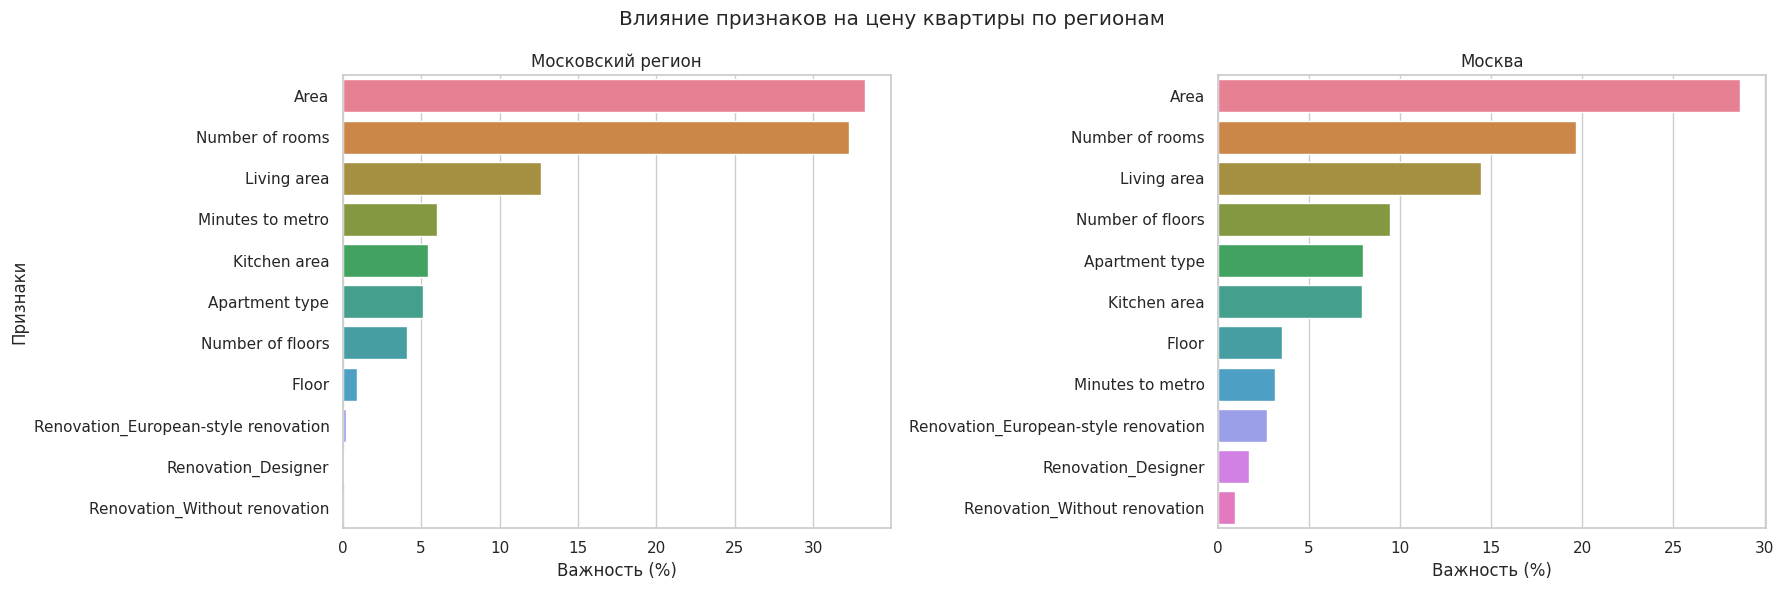

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), dpi=100, tight_layout=True)

sns.barplot(data=features, y='Признаки', x='Важность (%)', hue='Признаки', ax=axes[0])
axes[0].set_title("Московский регион")

sns.barplot(data=features_city, y='Признаки', x='Важность (%)', hue='Признаки', ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_title("Москва")

plt.suptitle("Влияние признаков на цену квартиры по регионам")
plt.show()

Важность Renovation_Cosmetic_renovation = 100% - (Сумма важностей остальных категорий ремонта). Подпризнак Renovation_Cosmetic_renovation представляет собой "базовый случай", т.е. в умолчанию все квартиры имеют Косметический ремонт.

---
**Анализ графика:**

1. **Московский регион:**
    * *Area (Площадь):* Самый важный признак с около 30% влияния на цену квартиры. Это вполне логично, так как общая площадь напрямую влияет на стоимость недвижимости.
    * *Number of rooms (Количество комнат):* Второй по важности признак, с примерно 25% влияния. Количество комнат также является важным фактором в определении цены, особенно в московском регионе, где квартиры с большим количеством комнат обычно стоят дороже.
    * *Living area (Жилая площадь):* Около 15% влияния. Жилая площадь также тесно связана с ценой, но уступает общей площади.
    * *Minutes to metro (Минуты до метро):* Важность около 10%. Время, необходимое для того, чтобы добраться до метро, также оказывает влияние на цену недвижимости в Московском регионе, но оно менее значимо по сравнению с площадью и количеством комнат.
    * *Kitchen area (Площадь кухни):* Примерно 7%. Важность кухни ниже, но она всё же является значимым фактором.
    * *Apartment type (Тип квартиры):* Около 5%. Тип квартиры (новостройка, вторичка и т.д.) влияет на цену, но не так сильно, как вышеуказанные признаки.
    * *Number of floors (Количество этажей):* Важность около 4%, что может отражать предпочтения покупателей относительно этажности здания.
    * *Floor (Этаж):* Примерно 2%. Этаж, на котором расположена квартира, также играет роль, но влияние довольно незначительное.
    * *Renovation (Ремонт):* Категории ремонта в целом имеют очень малую важность, что указывает на то, что в Московском регионе тип ремонта имеет менее значительное влияние на цену квартиры.
2. **Москва:**
    * *Area (Площадь):* Как и в Московском регионе, это самый важный признак, но здесь его влияние немного ниже — около 28%.
    * *Number of rooms (Количество комнат):* Второй по важности признак с около 22% влияния, аналогично Московскому региону.
    * *Living area (Жилая площадь):* Примерно 15% влияния, что аналогично значению в Московском регионе.
    * *Number of floors (Количество этажей):* Этот признак в Москве имеет большее влияние — около 10%, что может указывать на большую значимость этажности для рынка недвижимости в столице.
    * *Apartment type (Тип квартиры):* Примерно 8% важности, чуть более значимый фактор по сравнению с Московским регионом.
    * *Kitchen area (Площадь кухни):* Около 7% важности, аналогично Московскому региону.
    * *Floor (Этаж):* Примерно 5% влияния, что выше, чем в Московском регионе.
    * *Minutes to metro (Минуты до метро):* Важность меньше — около 4%, что может быть связано с большим количеством альтернативных транспортных опций в Москве.
    * *Renovation (Ремонт):* Категории ремонта в Москве также имеют очень малое влияние на цену квартиры, но чуть выше, чем в Московском регионе.

---

---
**Заключение:**

1. Площадь и количество комнат оказывают наибольшее влияние на цену квартиры в обоих регионах.
2. В Московском регионе более важны такие факторы, как расстояние до метро, тогда как в Москве этаж и этажность здания оказывают большее влияние.
3. Ремонт (категории ремонта) оказывает незначительное влияние на цену квартир в обоих регионах, что указывает на то, что покупатели больше ориентируются на другие факторы (например, площадь, количество комнат, этажность) при принятии решения о покупке квартиры.

Таким образом, ключевыми драйверами цены остаются площадь, количество комнат и жилая площадь, тогда как ремонт не является определяющим фактором в этих двух регионах.

---